### A股市场的月频因子
参考文献《Anomalies in Chinese A-Shares》，从tushares拉取相关数据，主要内容为检验了论文中除了风险相关的三个因子的其它因子的多空因子组合，复现了Table1的结果。 <br/>

#### （1）从tushares拉取数据
#### （1.1）一些全局的日期、stklist等数据

In [1]:
import tushare as ts
import numpy as np
import pandas as pd
import os
import datetime
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline

ts.set_token('')

pro = ts.pro_api()

def get_month_last_data(start_date, end_date):
    """
    获取月末交易日期的函数：
    获取月末交易日期tr_mon_last_date、月末自然日期mon_last_date
    Inputs:
        start_date: 开始日期
        end_date: 结束日期
    Ouputs:
        tr_mon_last_date, mon_last_date
        其中：
        tr_mon_last_date是月末交易日期
        mon_last_date是月末自然日期
    """
    trdate = pro.trade_cal(start_date=start_date, end_date=end_date)
    trdate['year'] = trdate['cal_date'].apply(lambda x: int(x[0:4]))  # 添加一个year、month列
    trdate['month'] = trdate['cal_date'].apply(lambda x: int(x[4:6]))
    tr_mon_last_date = trdate[ trdate['is_open'] == 1 ].groupby(['year', 'month']).last()
    tr_mon_last_date = list(tr_mon_last_date.cal_date)
    mon_last_date = trdate.groupby(['year', 'month']).last()
    mon_last_date = list(mon_last_date.cal_date)
    
    return tr_mon_last_date, mon_last_date

# 交易日信息
tr_mon_last_date, mon_last_date = get_month_last_data(start_date='19931201', end_date='20181130')

# 股票信息
stklist = pro.stock_basic(exchange='', list_status='', fields='ts_code, name, list_date')
print('stklist:')
print(stklist.head(5))

# 数据保存的文件夹
data_dir = os.sys.path[0] + '\\data\\sample_A_shares_factors'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)  # 如果不存在文件夹，先建立一个

stklist:
     ts_code  name list_date
0  000001.SZ  平安银行  19910403
1  000002.SZ   万科A  19910129
2  000004.SZ  国农科技  19910114
3  000005.SZ  世纪星源  19901210
4  000006.SZ  深振业A  19920427


#### （1.2）拉取股票月度数据的函数

In [2]:
# calculate_df_pchg
def calculate_df_pchg(arrLike, value, lag_value, condition, lag_condition):
    '''
    在dataframe里计算变动百分比的函数(用apply)，在这个dataframe的结构中，一般是以(group, date)为排序序列，
    如果在计算的时候只是简单地进行前后项目求差，则可能会跨越group出现错误，这个函数可以避免这个问题。
    Inputs:
        value：计算变动百分比的后一期值
        lag_value: 计算变动百分比的前一期值
        condition: group的后一期值
        lag_condition: group的前一期值
    Outputs:
        pchg_value: 变动百分比数值，如果出现了跨越group的情况，则设为nan（如每个group的第一个观测）
    '''
    value = arrLike[value]
    lag_value = arrLike[lag_value]
    condition = arrLike[condition]
    lag_condition = arrLike[lag_condition]
    if (condition == lag_condition) & (lag_value > 0):
        pchg_value = value / lag_value - 1
    else:
        pchg_value = np.nan
    return pchg_value

# filling_df_data
def filling_df_data(df, freq, filltype):
    """
    由于ts数据库在股票停牌月度时会缺失数据（影响月收益和市值的获取），所以需要进行填充处理
    Inputs:
        df: 需要填充处理的DataFrame
        freq: 填充的频率
        filltype: 填充的方式(asfreq/ffill/bfill)
        (这里实际上用的就是resample，所以设置是一致的)
    Outputs:
        df_filled: 填充后的DataFrame
    """
    df_filled = df.copy()
    df_filled['date'] = pd.to_datetime(df_filled['trade_date'])  # 将trade_date改成datetime格式，并设置为index
    df_filled.set_index(['date'], inplace=True)
    
    if filltype == 'asfreq':  # resample重采样(以ts_code来groupby)
        df_filled = df_filled.groupby('ts_code').resample(freq).asfreq()  # 填充缺省值
    elif filltype == 'ffill':
        df_filled = df_filled.groupby('ts_code').resample(freq).ffill()  # 前值填充
    elif filltype == 'bfill':
        df_filled = df_filled.groupby('ts_code').resample(freq).bfill()  # 后值填充
    df_filled.drop(columns=['ts_code'], inplace=True)
    df_filled = df_filled.reset_index()
    df_filled['trade_date'] = df_filled['date'].apply(lambda x: x.strftime('%Y%m%d'))  # 把trade_date也更新一下
    df_filled.drop(columns=['date'], inplace=True)
    return df_filled

# get_mon_ret_data
def get_mon_ret_data(tr_datelist, datelist):
    """
    从tushare获得指定日期段内的全部A股月度收益数据。注意，由于ts的《月线行情》里的pct_chg没有考虑分红除权的影响，
    因此这里需要用月收盘价+月末复权因子进行计算。
    Inputs:
        tr_datelist: 月末交易日期，用于提取个股月度收盘价
        datelist: 月末自然日期，用于提取个股月度复权因子
    Outputs:
        ret_monthly: 月度收益DataFrame
    """
    # (1)获取个股月度收盘价
    close_monthly = pd.DataFrame()
    for tr_date in datelist:
        if_get_data = 0
        while if_get_data == 0:
            try:
                df = pro.monthly(trade_date=tr_date, fields='ts_code, trade_date, close')
                close_monthly = close_monthly.append(df)
                print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))+': get momclose data of ' + tr_date)
                if_get_data = 1
                time.sleep(0.5)  # API有每分钟拉取次数限制，这里sleep一下降低频率
            except Exception as error:
                print(error)
                time.sleep(0.5)  # 出错了也sleep一下
    close_monthly['year'] = close_monthly['trade_date'].apply(lambda x: x[0:4])
    close_monthly['month'] = close_monthly['trade_date'].apply(lambda x: x[4:6])
    # (2)获取个股的复权因子
    factor_monthly = pd.DataFrame()
    for tr_date in tr_datelist:
        if_get_data = 0
        while if_get_data == 0:
            try:
                df = pro.adj_factor(trade_date=tr_date, fields='ts_code, trade_date, adj_factor')
                factor_monthly = factor_monthly.append(df)
                print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))+': get momfactor data of ' + tr_date)
                if_get_data = 1
                time.sleep(0.5)  # API有每分钟拉取次数限制，这里sleep一下降低频率
            except Exception as error:
                print(error)
                time.sleep(0.5)  # 出错了也sleep一下
    factor_monthly['year'] = factor_monthly['trade_date'].apply(lambda x: x[0:4])
    factor_monthly['month'] = factor_monthly['trade_date'].apply(lambda x: x[4:6])
    factor_monthly.drop(columns=['trade_date'], inplace=True)
    # (3)计算月收益率
    ## (3.1) 计算复权价格
    ret_monthly = pd.merge(close_monthly, factor_monthly, left_on=['ts_code', 'year', 'month'], right_on=['ts_code', 'year', 'month'], how='outer')
    ret_monthly['adj_price'] = ret_monthly['close'] * ret_monthly['adj_factor']
    ret_monthly.dropna(inplace=True)
    ## (3.2) 从复权价格得到月收益
    ret_monthly.drop(columns=['year', 'month', 'close', 'adj_factor'], inplace=True)
    ret_monthly.sort_values(['ts_code', 'trade_date'], inplace=True)
    ret_monthly['b_ts_code_1'], ret_monthly['b_adj_price_1'] = ret_monthly['ts_code'].shift(1), ret_monthly['adj_price'].shift(1)
    ret_monthly['rR_mon'] = ret_monthly.apply(calculate_df_pchg, axis=1, args=('adj_price', 'b_adj_price_1', 'ts_code', 'b_ts_code_1'))
    ret_monthly.drop(columns=['b_ts_code_1', 'adj_price', 'b_adj_price_1'], inplace=True)
    ret_monthly.dropna(inplace=True)
    # (4)return
    return ret_monthly


# get_mon_size_data
def get_mon_size_data(datelist):
    """
    从tushare获得指定日期段内的全部A股月度市值数据。
    Inputs:
        datelist: 月末自然日期
    Outputs:
        mkt_value_monthly
    """
    # (1)获取数据
    mkt_value_monthly = pd.DataFrame()
    for tr_date in datelist:
        if_get_data = 0
        while if_get_data == 0:
            try:
                df = pro.daily_basic(ts_code='', trade_date=tr_date, fields='ts_code, trade_date, total_mv')
                mkt_value_monthly = mkt_value_monthly.append(df)
                print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))+': get size data of ' + tr_date)
                if_get_data = 1
                time.sleep(0.5)  # API有每分钟拉取次数限制，这里sleep一下降低频率
            except Exception as error:
                print(error)
                time.sleep(0.5)  # 出错了也sleep一下                     
    mkt_value_monthly = mkt_value_monthly.sort_values(['ts_code', 'trade_date']).reset_index(drop=True)
    # (2)return
    return mkt_value_monthly

# get_asset_data
def get_asset_data(stklist, start_date, end_date):
    """
    从tushare获得指定日期段内的全部A股的资产负债表中的相关数据。注意，这里只抽取年报的信息。所获取的数据会进一步加工为factor。
    Inputs:
        stklist: 股票列表
        start_date: 开始日期
        end_date: 结束日期
    Outputs:
        assets
    """
    # (1)获取数据
    assets = pd.DataFrame()
    for scode in stklist:
        if_get_data = 0
        while if_get_data == 0:
            try:
                df = pro.balancesheet(ts_code=scode, start_date=start_date, end_date=end_date, 
                              fields='ts_code, ann_date, f_ann_date, end_date, report_type, comp_type,' +\
                                     'total_assets, total_hldr_eqy_exc_min_int,' +\
                                     'notes_receiv, accounts_receiv, oth_receiv, prepayment, inventories,' +\
                                     'notes_payable, acct_payable, adv_receipts')
                print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))+': get asset data of ' + scode)
                if_get_data = 1
                time.sleep(1)  # API有每分钟拉取次数限制，这里sleep一下降低频率
            except Exception as error:
                print(error)
                time.sleep(1)  # 出错了也sleep一下
        df.fillna(0, inplace=True)  # 用0填充nan值
        # (2)筛选或初步加工数据
        ## (2.1)抽取年报信息
        df['day'] = df['end_date'].apply(lambda x: x[-4:])
        df = df[df['day'] == '1231'].drop(columns=['day'])  # 抽取年报信息
        ## (2.2)初步加工一些数据，并且设置金融企业的相关数据为缺省值(以经营性的财报数据为主)
        df['book_values'] = df['total_hldr_eqy_exc_min_int']  # 净资产   
        df['net_op_assets'] = (df['notes_receiv'] + df['accounts_receiv'] + df ['oth_receiv'] + df['prepayment'] + df['inventories']) -\
                              (df['notes_payable'] - df['acct_payable'] - df['adv_receipts'])  # 经营性净资产
        df.net_op_assets[df['comp_type'] != '1'] = np.nan  # 金融企业不计算经营净资产
        df_columns = df.columns[[0, 1, 2, 3, 4, 5, 11, 16, 17]]
        df = df[df_columns]
        assets = assets.append(df)  
    assets = assets.sort_values(['ts_code', 'end_date'])
    # (3)return
    return assets

# get_income_data
def get_income_data(stklist, start_date, end_date):
    """
    从tushare获得指定日期段内的全部A股的利润表中的相关数据。注意，这里只抽取年报的信息。所获取的数据会进一步加工为factor。
    Inputs:
        stklist: 股票列表
        start_date: 开始日期
        end_date: 结束日期
    Outputs:
        incomes
    """
    # (1)获取数据
    incomes = pd.DataFrame()
    for scode in stklist:
        if_get_data = 0
        while if_get_data == 0:
            try:     
                df = pro.income(ts_code=scode, start_date=start_date, end_date=end_date, 
                fields='ts_code, ann_date, f_ann_date, end_date, report_type , comp_type,' +\
                       'total_revenue, total_cogs, int_exp, admin_exp, n_income_attr_p')
                print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))+': get income data of ' + scode)
                if_get_data = 1
                time.sleep(1)  # API有每分钟拉取次数限制，这里sleep一下降低频率
            except Exception as error:
                print(error)
                time.sleep(1)  # 出错了也sleep一下
        df.fillna(0, inplace=True)  # 用0填充nan值
        # (2)筛选或初步加工数据
        ## (2.1)抽取年报信息
        df['day'] = df['end_date'].apply(lambda x: x[-4:])
        df = df[df['day'] == '1231'].drop(columns=['day'])  # 抽取年报信息
        ## (2.2)初步加工一些数据，并且设置金融企业的相关数据为缺省值(以经营性的财报数据为主)
        df['revenue'] = df['total_revenue']  # 总收入
        df['profit'] = df['n_income_attr_p']  # 总利润 
        df['gross_profit'] = df['revenue'] - df['total_cogs']  # 毛利润
        df['operate_profit'] = df['revenue'] - df['total_cogs'] - df['admin_exp'] - df['int_exp']  # 经营利润
        df.operate_profit[df['comp_type'] != '1'] = np.nan  # 金融企业不计算经营利润
        df_columns = df.columns[[0, 1, 2, 3, 4, 5, 11, 12, 13, 14]]
        df = df[df_columns]
        incomes = incomes.append(df)  
    incomes = incomes.sort_values(['ts_code', 'end_date'])
    # (3)return
    return incomes

# get_cashflow_data
def get_cashflow_data(stklist, start_date, end_date):
    """
    从tushare获得指定日期段内的全部A股的现金流量表中的相关数据。注意，这里只抽取年报的信息。所获取的数据会进一步加工为factor。
    Inputs:
        stklist: 股票列表
        start_date: 开始日期
        end_date: 结束日期
    Outputs:
        cashflows
    """
    # (1)获取数据
    cashflows = pd.DataFrame()
    for scode in stklist:
        if_get_data = 0
        while if_get_data == 0:
            try:     
                df = pro.cashflow(ts_code=scode, start_date=start_date, end_date=end_date, 
                fields='ts_code, ann_date, f_ann_date, end_date, report_type , comp_type, n_cashflow_act')
                print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))+': get cashflow data of ' + scode)
                if_get_data = 1
                time.sleep(1)  # API有每分钟拉取次数限制，这里sleep一下降低频率
            except Exception as error:
                print(error)
                time.sleep(1)  # 出错了也sleep一下
        df.fillna(0, inplace=True)  # 用0填充nan值
        # (2)筛选或初步加工数据
        ## (2.1)抽取年报信息
        df['day'] = df['end_date'].apply(lambda x: x[-4:])
        df = df[df['day'] == '1231'].drop(columns=['day'])  # 抽取年报信息
        ## (2.2)初步加工一些数据，并且设置金融企业的相关数据为缺省值(以经营性的财报数据为主)
        df['net_op_cashflow'] = df['n_cashflow_act']  # 经营性现金流净值
        df.net_op_cashflow[df['comp_type'] != '1'] = np.nan  # 金融企业不计算经营现金流净值
        df_columns = df.columns[[0, 1, 2, 3, 4, 5, 7]]
        df = df[df_columns]
        cashflows = cashflows.append(df)  
    cashflows = cashflows.sort_values(['ts_code', 'end_date'])
    # (3)return
    return cashflows

# get_div_data
def get_div_data(stklist):
    """
    从tushare获得指定日期段内的全部A股的现金红利的相关数据。注意，这里只抽取年报的信息。所获取的数据会进一步加工为factor。
    Inputs:
        stklist: 股票列表
    Outputs:
        divs
    """
    # (1)获取数据
    divs = pd.DataFrame()
    for scode in stklist:
        if_get_data = 0
        while if_get_data == 0:
            try:     
                df = pro.dividend(ts_code=scode, fields='ts_code, end_date, div_proc, cash_div_tax, base_share')
                print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))+': get dividend data of ' + scode)
                if_get_data = 1
                time.sleep(1)  # API有每分钟拉取次数限制，这里sleep一下降低频率
            except Exception as error:
                print(error)
                time.sleep(1)  # 出错了也sleep一下
        df.fillna(0, inplace=True)  # 用0填充nan值
        # (2)筛选或初步加工数据，将一年内所有的分红情况都归总到该年12/31
        df = df[df['div_proc'] == '实施']
        df['cash_div_all'] = df['cash_div_tax'] * df['base_share'] * 1e4  # 分红现金额
        df['end_date'] = df['end_date'].apply(lambda x: x[0:4]+'1231')  # 把end_date都转换为该年的1231
        df.drop(columns=['div_proc', 'cash_div_tax', 'base_share'], inplace=True)
        df = df.groupby(['ts_code', 'end_date']).sum()
        df.reset_index(inplace=True)
        divs = divs.append(df)
    divs = divs.sort_values(['ts_code', 'end_date'])
    # (3)return
    return divs

In [3]:
# (1.2.1)拉取月度收益数据
ret_monthly = get_mon_ret_data(tr_datelist=tr_mon_last_date, datelist=mon_last_date)  # 拉取数据
ret_monthly_filled = filling_df_data(df=ret_monthly, freq='1M', filltype='asfreq')  # 按月度填充
ret_monthly_filled.drop_duplicates(subset=['ts_code', 'trade_date'], keep='last', inplace=True)  # 去重
# 把数据保存下来，不用每次都从ts拉取数据
csv_path = data_dir + '\\ret_monthly_filled.csv'
ret_monthly_filled.to_csv(csv_path)

2018-12-30 17:40:11: get momclose data of 19931231
2018-12-30 17:40:12: get momclose data of 19940131
2018-12-30 17:40:12: get momclose data of 19940228
2018-12-30 17:40:13: get momclose data of 19940331
2018-12-30 17:40:14: get momclose data of 19940430
2018-12-30 17:40:14: get momclose data of 19940531
2018-12-30 17:40:15: get momclose data of 19940630
2018-12-30 17:40:16: get momclose data of 19940731
2018-12-30 17:40:16: get momclose data of 19940831
2018-12-30 17:40:17: get momclose data of 19940930
2018-12-30 17:40:18: get momclose data of 19941031
2018-12-30 17:40:18: get momclose data of 19941130
2018-12-30 17:40:19: get momclose data of 19941231
2018-12-30 17:40:20: get momclose data of 19950131
2018-12-30 17:40:20: get momclose data of 19950228
2018-12-30 17:40:21: get momclose data of 19950331
2018-12-30 17:40:21: get momclose data of 19950430
2018-12-30 17:40:22: get momclose data of 19950531
2018-12-30 17:40:23: get momclose data of 19950630
2018-12-30 17:40:23: get momclo

2018-12-30 17:41:58: get momclose data of 20070531
2018-12-30 17:41:59: get momclose data of 20070630
2018-12-30 17:41:59: get momclose data of 20070731
2018-12-30 17:42:00: get momclose data of 20070831
2018-12-30 17:42:01: get momclose data of 20070930
2018-12-30 17:42:02: get momclose data of 20071031
2018-12-30 17:42:02: get momclose data of 20071130
2018-12-30 17:42:03: get momclose data of 20071231
2018-12-30 17:42:04: get momclose data of 20080131
2018-12-30 17:42:04: get momclose data of 20080229
2018-12-30 17:42:05: get momclose data of 20080331
2018-12-30 17:42:06: get momclose data of 20080430
2018-12-30 17:42:07: get momclose data of 20080531
2018-12-30 17:42:07: get momclose data of 20080630
2018-12-30 17:42:08: get momclose data of 20080731
2018-12-30 17:42:09: get momclose data of 20080831
2018-12-30 17:42:09: get momclose data of 20080930
2018-12-30 17:42:10: get momclose data of 20081031
2018-12-30 17:42:11: get momclose data of 20081130
2018-12-30 17:42:12: get momclo

2018-12-30 17:43:55: get momfactor data of 19951031
2018-12-30 17:43:56: get momfactor data of 19951130
2018-12-30 17:43:56: get momfactor data of 19951229
2018-12-30 17:43:57: get momfactor data of 19960131
2018-12-30 17:43:58: get momfactor data of 19960216
2018-12-30 17:43:58: get momfactor data of 19960329
2018-12-30 17:43:59: get momfactor data of 19960430
2018-12-30 17:44:00: get momfactor data of 19960531
2018-12-30 17:44:00: get momfactor data of 19960628
2018-12-30 17:44:01: get momfactor data of 19960731
2018-12-30 17:44:02: get momfactor data of 19960830
2018-12-30 17:44:02: get momfactor data of 19960927
2018-12-30 17:44:03: get momfactor data of 19961031
2018-12-30 17:44:04: get momfactor data of 19961129
2018-12-30 17:44:04: get momfactor data of 19961231
2018-12-30 17:44:05: get momfactor data of 19970131
2018-12-30 17:44:06: get momfactor data of 19970228
2018-12-30 17:44:06: get momfactor data of 19970331
2018-12-30 17:44:07: get momfactor data of 19970430
2018-12-30 1

2018-12-30 17:45:41: get momfactor data of 20081231
2018-12-30 17:45:42: get momfactor data of 20090123
2018-12-30 17:45:42: get momfactor data of 20090227
2018-12-30 17:45:43: get momfactor data of 20090331
2018-12-30 17:45:44: get momfactor data of 20090430
2018-12-30 17:45:44: get momfactor data of 20090527
2018-12-30 17:45:45: get momfactor data of 20090630
2018-12-30 17:45:46: get momfactor data of 20090731
2018-12-30 17:45:46: get momfactor data of 20090831
2018-12-30 17:45:47: get momfactor data of 20090930
2018-12-30 17:45:48: get momfactor data of 20091030
2018-12-30 17:45:48: get momfactor data of 20091130
2018-12-30 17:45:49: get momfactor data of 20091231
2018-12-30 17:45:50: get momfactor data of 20100129
2018-12-30 17:45:51: get momfactor data of 20100226
2018-12-30 17:45:51: get momfactor data of 20100331
2018-12-30 17:45:52: get momfactor data of 20100430
2018-12-30 17:45:53: get momfactor data of 20100531
2018-12-30 17:45:53: get momfactor data of 20100630
2018-12-30 1

In [4]:
# (1.2.2)拉取市值数据
# 获取并填充数据
mkt_value_monthly = get_mon_size_data(tr_mon_last_date)  # 拉取数据
mkt_value_monthly_filled = filling_df_data(df=mkt_value_monthly, freq='1M', filltype='ffill')  # 按月度填充，注意pandas的前值填充并不是填充前一个采样点的值，而是前一个原序列最近的值(这个逻辑保证了数据的准确)
mkt_value_monthly_filled['total_mv'] = mkt_value_monthly_filled['total_mv'] * 1e4  # 单位换算为元
# 获取上一个月月末的市值，成为因子
size = mkt_value_monthly_filled.copy()
size['SIZE'] = size['total_mv'].shift(1)
size['b_code_1'] = size['ts_code'].shift(1)
size = size[ size['ts_code'] == size['b_code_1'] ]
size.drop(columns=['b_code_1', 'total_mv'], inplace=True)
size.drop_duplicates(subset=['ts_code', 'trade_date'], keep='last', inplace=True)  # 去重
csv_path = data_dir + '\\size.csv'
size.to_csv(csv_path)

2018-12-30 17:48:44: get size data of 19931231
2018-12-30 17:48:44: get size data of 19940131
2018-12-30 17:48:45: get size data of 19940228
2018-12-30 17:48:46: get size data of 19940331
2018-12-30 17:48:46: get size data of 19940429
2018-12-30 17:48:47: get size data of 19940531
2018-12-30 17:48:47: get size data of 19940630
2018-12-30 17:48:48: get size data of 19940729
2018-12-30 17:48:49: get size data of 19940831
2018-12-30 17:48:49: get size data of 19940930
2018-12-30 17:48:50: get size data of 19941031
2018-12-30 17:48:51: get size data of 19941130
2018-12-30 17:48:51: get size data of 19941230
2018-12-30 17:48:52: get size data of 19950127
2018-12-30 17:48:53: get size data of 19950228
2018-12-30 17:48:53: get size data of 19950331
2018-12-30 17:48:54: get size data of 19950428
2018-12-30 17:48:55: get size data of 19950531
2018-12-30 17:48:55: get size data of 19950630
2018-12-30 17:48:56: get size data of 19950731
2018-12-30 17:48:57: get size data of 19950831
2018-12-30 17

2018-12-30 17:50:41: get size data of 20080731
2018-12-30 17:50:42: get size data of 20080829
2018-12-30 17:50:42: get size data of 20080926
2018-12-30 17:50:43: get size data of 20081031
2018-12-30 17:50:44: get size data of 20081128
2018-12-30 17:50:45: get size data of 20081231
2018-12-30 17:50:45: get size data of 20090123
2018-12-30 17:50:46: get size data of 20090227
2018-12-30 17:50:47: get size data of 20090331
2018-12-30 17:50:48: get size data of 20090430
2018-12-30 17:50:48: get size data of 20090527
2018-12-30 17:50:49: get size data of 20090630
2018-12-30 17:50:50: get size data of 20090731
2018-12-30 17:50:51: get size data of 20090831
2018-12-30 17:50:51: get size data of 20090930
2018-12-30 17:50:52: get size data of 20091030
2018-12-30 17:50:53: get size data of 20091130
2018-12-30 17:50:54: get size data of 20091231
2018-12-30 17:50:54: get size data of 20100129
2018-12-30 17:50:55: get size data of 20100226
2018-12-30 17:50:56: get size data of 20100331
2018-12-30 17

In [5]:
# (1.2.3)拉取资产负债表的数据
# 获取数据
assets = get_asset_data(list(stklist['ts_code']), '19931201', '20181130')
assets.drop_duplicates(subset=['ts_code', 'end_date'], keep='last', inplace=True)  # 去重
# 计算总资产和净资产的增长率
assets['b_ts_code_1'], assets['b_total_assets_1'], assets['b_book_values_1'] = assets['ts_code'].shift(1), assets['total_assets'].shift(1), assets['book_values'].shift(1)
assets['total_assets_pchg'] = assets.apply(calculate_df_pchg, axis=1, args=('total_assets', 'b_total_assets_1', 'ts_code', 'b_ts_code_1'))
assets['book_values_pchg'] = assets.apply(calculate_df_pchg, axis=1, args=('book_values', 'b_book_values_1', 'ts_code', 'b_ts_code_1'))
assets.drop(columns=['b_ts_code_1', 'b_total_assets_1', 'b_book_values_1'], inplace=True)
csv_path = data_dir + '\\assets.csv'
assets.to_csv(csv_path)

2018-12-30 17:52:54: get asset data of 000001.SZ


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2018-12-30 17:52:55: get asset data of 000002.SZ
2018-12-30 17:52:56: get asset data of 000004.SZ
2018-12-30 17:53:02: get asset data of 000005.SZ
2018-12-30 17:53:03: get asset data of 000006.SZ
2018-12-30 17:53:04: get asset data of 000007.SZ
2018-12-30 17:53:06: get asset data of 000008.SZ
2018-12-30 17:53:07: get asset data of 000009.SZ
2018-12-30 17:53:08: get asset data of 000010.SZ
2018-12-30 17:53:09: get asset data of 000011.SZ
2018-12-30 17:53:10: get asset data of 000012.SZ
2018-12-30 17:53:12: get asset data of 000014.SZ
2018-12-30 17:53:13: get asset data of 000016.SZ
2018-12-30 17:53:14: get asset data of 000017.SZ
2018-12-30 17:53:15: get asset data of 000018.SZ
2018-12-30 17:53:16: get asset data of 000019.SZ
2018-12-30 17:53:17: get asset data of 000020.SZ
2018-12-30 17:53:19: get asset data of 000021.SZ
2018-12-30 17:53:20: get asset data of 000023.SZ
2018-12-30 17:53:21: get asset data of 000025.SZ
2018-12-30 17:53:22: get asset data of 000026.SZ
2018-12-30 17:53:23:

2018-12-30 17:56:18: get asset data of 000590.SZ
2018-12-30 17:56:20: get asset data of 000591.SZ
2018-12-30 17:56:21: get asset data of 000592.SZ
2018-12-30 17:56:22: get asset data of 000593.SZ
2018-12-30 17:56:23: get asset data of 000595.SZ
2018-12-30 17:56:24: get asset data of 000596.SZ
2018-12-30 17:56:25: get asset data of 000597.SZ
2018-12-30 17:56:27: get asset data of 000598.SZ
2018-12-30 17:56:28: get asset data of 000599.SZ
2018-12-30 17:56:29: get asset data of 000600.SZ
2018-12-30 17:56:30: get asset data of 000601.SZ
2018-12-30 17:56:31: get asset data of 000603.SZ
2018-12-30 17:56:33: get asset data of 000605.SZ
2018-12-30 17:56:34: get asset data of 000606.SZ
2018-12-30 17:56:35: get asset data of 000607.SZ
2018-12-30 17:56:36: get asset data of 000608.SZ
2018-12-30 17:56:37: get asset data of 000609.SZ
2018-12-30 17:56:38: get asset data of 000610.SZ
2018-12-30 17:56:40: get asset data of 000611.SZ
2018-12-30 17:56:41: get asset data of 000612.SZ
2018-12-30 17:56:42:

2018-12-30 17:59:36: get asset data of 000825.SZ
2018-12-30 17:59:37: get asset data of 000826.SZ
2018-12-30 17:59:38: get asset data of 000828.SZ
2018-12-30 17:59:40: get asset data of 000829.SZ
2018-12-30 17:59:41: get asset data of 000830.SZ
2018-12-30 17:59:42: get asset data of 000831.SZ
2018-12-30 17:59:43: get asset data of 000833.SZ
2018-12-30 17:59:44: get asset data of 000835.SZ
2018-12-30 17:59:46: get asset data of 000836.SZ
2018-12-30 17:59:47: get asset data of 000837.SZ
2018-12-30 17:59:48: get asset data of 000838.SZ
2018-12-30 17:59:49: get asset data of 000839.SZ
2018-12-30 17:59:50: get asset data of 000848.SZ
2018-12-30 17:59:51: get asset data of 000850.SZ
2018-12-30 17:59:53: get asset data of 000851.SZ
2018-12-30 17:59:54: get asset data of 000852.SZ
2018-12-30 17:59:55: get asset data of 000856.SZ
2018-12-30 17:59:56: get asset data of 000858.SZ
2018-12-30 17:59:57: get asset data of 000859.SZ
2018-12-30 17:59:58: get asset data of 000860.SZ
2018-12-30 18:00:00:

2018-12-30 18:02:58: get asset data of 002042.SZ
2018-12-30 18:02:59: get asset data of 002043.SZ
2018-12-30 18:03:00: get asset data of 002044.SZ
2018-12-30 18:03:02: get asset data of 002045.SZ
2018-12-30 18:03:03: get asset data of 002046.SZ
2018-12-30 18:03:04: get asset data of 002047.SZ
2018-12-30 18:03:05: get asset data of 002048.SZ
2018-12-30 18:03:06: get asset data of 002049.SZ
2018-12-30 18:03:08: get asset data of 002050.SZ
2018-12-30 18:03:09: get asset data of 002051.SZ
2018-12-30 18:03:10: get asset data of 002052.SZ
2018-12-30 18:03:11: get asset data of 002053.SZ
2018-12-30 18:03:12: get asset data of 002054.SZ
2018-12-30 18:03:13: get asset data of 002055.SZ
2018-12-30 18:03:15: get asset data of 002056.SZ
2018-12-30 18:03:16: get asset data of 002057.SZ
2018-12-30 18:03:17: get asset data of 002058.SZ
2018-12-30 18:03:18: get asset data of 002059.SZ
2018-12-30 18:03:19: get asset data of 002060.SZ
2018-12-30 18:03:20: get asset data of 002061.SZ
2018-12-30 18:03:22:

2018-12-30 18:06:16: get asset data of 002210.SZ
2018-12-30 18:06:17: get asset data of 002211.SZ
2018-12-30 18:06:18: get asset data of 002212.SZ
2018-12-30 18:06:19: get asset data of 002213.SZ
2018-12-30 18:06:20: get asset data of 002214.SZ
2018-12-30 18:06:21: get asset data of 002215.SZ
2018-12-30 18:06:23: get asset data of 002216.SZ
2018-12-30 18:06:24: get asset data of 002217.SZ
2018-12-30 18:06:25: get asset data of 002218.SZ
2018-12-30 18:06:26: get asset data of 002219.SZ
2018-12-30 18:06:27: get asset data of 002220.SZ
2018-12-30 18:06:28: get asset data of 002221.SZ
2018-12-30 18:06:30: get asset data of 002222.SZ
2018-12-30 18:06:31: get asset data of 002223.SZ
2018-12-30 18:06:32: get asset data of 002224.SZ
2018-12-30 18:06:33: get asset data of 002225.SZ
2018-12-30 18:06:34: get asset data of 002226.SZ
2018-12-30 18:06:36: get asset data of 002227.SZ
2018-12-30 18:06:37: get asset data of 002228.SZ
2018-12-30 18:06:38: get asset data of 002229.SZ
2018-12-30 18:06:39:

2018-12-30 18:09:38: get asset data of 002379.SZ
2018-12-30 18:09:39: get asset data of 002380.SZ
2018-12-30 18:09:40: get asset data of 002381.SZ
2018-12-30 18:09:41: get asset data of 002382.SZ
2018-12-30 18:09:43: get asset data of 002383.SZ
2018-12-30 18:09:44: get asset data of 002384.SZ
2018-12-30 18:09:45: get asset data of 002385.SZ
2018-12-30 18:09:46: get asset data of 002386.SZ
2018-12-30 18:09:47: get asset data of 002387.SZ
2018-12-30 18:09:48: get asset data of 002388.SZ
2018-12-30 18:09:50: get asset data of 002389.SZ
2018-12-30 18:09:51: get asset data of 002390.SZ
2018-12-30 18:09:52: get asset data of 002391.SZ
2018-12-30 18:09:53: get asset data of 002392.SZ
2018-12-30 18:09:54: get asset data of 002393.SZ
2018-12-30 18:09:55: get asset data of 002394.SZ
2018-12-30 18:09:57: get asset data of 002395.SZ
2018-12-30 18:09:58: get asset data of 002396.SZ
2018-12-30 18:09:59: get asset data of 002397.SZ
2018-12-30 18:10:00: get asset data of 002398.SZ
2018-12-30 18:10:01:

2018-12-30 18:12:55: get asset data of 002548.SZ
2018-12-30 18:12:56: get asset data of 002549.SZ
2018-12-30 18:12:57: get asset data of 002550.SZ
2018-12-30 18:12:58: get asset data of 002551.SZ
2018-12-30 18:12:59: get asset data of 002552.SZ
2018-12-30 18:13:00: get asset data of 002553.SZ
2018-12-30 18:13:02: get asset data of 002554.SZ
2018-12-30 18:13:03: get asset data of 002555.SZ
2018-12-30 18:13:04: get asset data of 002556.SZ
2018-12-30 18:13:05: get asset data of 002557.SZ
2018-12-30 18:13:06: get asset data of 002558.SZ
2018-12-30 18:13:07: get asset data of 002559.SZ
2018-12-30 18:13:09: get asset data of 002560.SZ
2018-12-30 18:13:10: get asset data of 002561.SZ
2018-12-30 18:13:11: get asset data of 002562.SZ
2018-12-30 18:13:12: get asset data of 002563.SZ
2018-12-30 18:13:13: get asset data of 002564.SZ
2018-12-30 18:13:14: get asset data of 002565.SZ
2018-12-30 18:13:16: get asset data of 002566.SZ
2018-12-30 18:13:17: get asset data of 002567.SZ
2018-12-30 18:13:18:

2018-12-30 18:16:16: get asset data of 002718.SZ
2018-12-30 18:16:18: get asset data of 002719.SZ
2018-12-30 18:16:19: get asset data of 002721.SZ
2018-12-30 18:16:20: get asset data of 002722.SZ
2018-12-30 18:16:21: get asset data of 002723.SZ
2018-12-30 18:16:22: get asset data of 002724.SZ
2018-12-30 18:16:23: get asset data of 002725.SZ
2018-12-30 18:16:25: get asset data of 002726.SZ
2018-12-30 18:16:26: get asset data of 002727.SZ
2018-12-30 18:16:27: get asset data of 002728.SZ
2018-12-30 18:16:28: get asset data of 002729.SZ
2018-12-30 18:16:29: get asset data of 002730.SZ
2018-12-30 18:16:31: get asset data of 002731.SZ
2018-12-30 18:16:32: get asset data of 002732.SZ
2018-12-30 18:16:33: get asset data of 002733.SZ
2018-12-30 18:16:34: get asset data of 002734.SZ
2018-12-30 18:16:35: get asset data of 002735.SZ
2018-12-30 18:16:36: get asset data of 002736.SZ
2018-12-30 18:16:38: get asset data of 002737.SZ
2018-12-30 18:16:39: get asset data of 002738.SZ
2018-12-30 18:16:40:

2018-12-30 18:19:38: get asset data of 002899.SZ
2018-12-30 18:19:40: get asset data of 002900.SZ
2018-12-30 18:19:41: get asset data of 002901.SZ
2018-12-30 18:19:42: get asset data of 002902.SZ
2018-12-30 18:19:43: get asset data of 002903.SZ
2018-12-30 18:19:44: get asset data of 002905.SZ
2018-12-30 18:19:45: get asset data of 002906.SZ
2018-12-30 18:19:47: get asset data of 002907.SZ
2018-12-30 18:19:48: get asset data of 002908.SZ
2018-12-30 18:19:49: get asset data of 002909.SZ
2018-12-30 18:19:50: get asset data of 002910.SZ
2018-12-30 18:19:51: get asset data of 002911.SZ
2018-12-30 18:19:52: get asset data of 002912.SZ
2018-12-30 18:19:53: get asset data of 002913.SZ
2018-12-30 18:19:55: get asset data of 002915.SZ
2018-12-30 18:19:56: get asset data of 002916.SZ
2018-12-30 18:19:57: get asset data of 002917.SZ
2018-12-30 18:19:58: get asset data of 002918.SZ
2018-12-30 18:19:59: get asset data of 002919.SZ
2018-12-30 18:20:00: get asset data of 002920.SZ
2018-12-30 18:20:02:

2018-12-30 18:22:55: get asset data of 300129.SZ
2018-12-30 18:22:57: get asset data of 300130.SZ
2018-12-30 18:22:58: get asset data of 300131.SZ
2018-12-30 18:22:59: get asset data of 300132.SZ
2018-12-30 18:23:00: get asset data of 300133.SZ
2018-12-30 18:23:02: get asset data of 300134.SZ
2018-12-30 18:23:03: get asset data of 300135.SZ
2018-12-30 18:23:04: get asset data of 300136.SZ
2018-12-30 18:23:05: get asset data of 300137.SZ
2018-12-30 18:23:06: get asset data of 300138.SZ
2018-12-30 18:23:07: get asset data of 300139.SZ
2018-12-30 18:23:09: get asset data of 300140.SZ
2018-12-30 18:23:10: get asset data of 300141.SZ
2018-12-30 18:23:11: get asset data of 300142.SZ
2018-12-30 18:23:12: get asset data of 300143.SZ
2018-12-30 18:23:13: get asset data of 300144.SZ
2018-12-30 18:23:14: get asset data of 300145.SZ
2018-12-30 18:23:16: get asset data of 300146.SZ
2018-12-30 18:23:17: get asset data of 300147.SZ
2018-12-30 18:23:18: get asset data of 300148.SZ
2018-12-30 18:23:19:

2018-12-30 18:26:12: get asset data of 300298.SZ
2018-12-30 18:26:13: get asset data of 300299.SZ
2018-12-30 18:26:15: get asset data of 300300.SZ
2018-12-30 18:26:16: get asset data of 300301.SZ
2018-12-30 18:26:17: get asset data of 300302.SZ
2018-12-30 18:26:18: get asset data of 300303.SZ
2018-12-30 18:26:19: get asset data of 300304.SZ
2018-12-30 18:26:21: get asset data of 300305.SZ
2018-12-30 18:26:22: get asset data of 300306.SZ
2018-12-30 18:26:23: get asset data of 300307.SZ
2018-12-30 18:26:24: get asset data of 300308.SZ
2018-12-30 18:26:25: get asset data of 300309.SZ
2018-12-30 18:26:26: get asset data of 300310.SZ
2018-12-30 18:26:28: get asset data of 300311.SZ
2018-12-30 18:26:29: get asset data of 300312.SZ
2018-12-30 18:26:30: get asset data of 300313.SZ
2018-12-30 18:26:31: get asset data of 300314.SZ
2018-12-30 18:26:32: get asset data of 300315.SZ
2018-12-30 18:26:33: get asset data of 300316.SZ
2018-12-30 18:26:35: get asset data of 300317.SZ
2018-12-30 18:26:36:

2018-12-30 18:29:29: get asset data of 300468.SZ
2018-12-30 18:29:30: get asset data of 300469.SZ
2018-12-30 18:29:32: get asset data of 300470.SZ
2018-12-30 18:29:33: get asset data of 300471.SZ
2018-12-30 18:29:34: get asset data of 300472.SZ
2018-12-30 18:29:35: get asset data of 300473.SZ
2018-12-30 18:29:36: get asset data of 300474.SZ
2018-12-30 18:29:38: get asset data of 300475.SZ
2018-12-30 18:29:39: get asset data of 300476.SZ
2018-12-30 18:29:40: get asset data of 300477.SZ
2018-12-30 18:29:41: get asset data of 300478.SZ
2018-12-30 18:29:42: get asset data of 300479.SZ
2018-12-30 18:29:43: get asset data of 300480.SZ
2018-12-30 18:29:45: get asset data of 300481.SZ
2018-12-30 18:29:46: get asset data of 300482.SZ
2018-12-30 18:29:47: get asset data of 300483.SZ
2018-12-30 18:29:48: get asset data of 300484.SZ
2018-12-30 18:29:49: get asset data of 300485.SZ
2018-12-30 18:29:50: get asset data of 300486.SZ
2018-12-30 18:29:52: get asset data of 300487.SZ
2018-12-30 18:29:53:

2018-12-30 18:32:45: get asset data of 300642.SZ
2018-12-30 18:32:46: get asset data of 300643.SZ
2018-12-30 18:32:48: get asset data of 300644.SZ
2018-12-30 18:32:49: get asset data of 300645.SZ
2018-12-30 18:32:50: get asset data of 300647.SZ
2018-12-30 18:32:51: get asset data of 300648.SZ
2018-12-30 18:32:52: get asset data of 300649.SZ
2018-12-30 18:32:53: get asset data of 300650.SZ
2018-12-30 18:32:55: get asset data of 300651.SZ
2018-12-30 18:32:56: get asset data of 300652.SZ
2018-12-30 18:32:57: get asset data of 300653.SZ
2018-12-30 18:32:58: get asset data of 300654.SZ
2018-12-30 18:32:59: get asset data of 300655.SZ
2018-12-30 18:33:00: get asset data of 300656.SZ
2018-12-30 18:33:02: get asset data of 300657.SZ
2018-12-30 18:33:03: get asset data of 300658.SZ
2018-12-30 18:33:04: get asset data of 300659.SZ
2018-12-30 18:33:05: get asset data of 300660.SZ
2018-12-30 18:33:06: get asset data of 300661.SZ
2018-12-30 18:33:07: get asset data of 300662.SZ
2018-12-30 18:33:09:

2018-12-30 18:36:09: get asset data of 600080.SH
2018-12-30 18:36:10: get asset data of 600081.SH
2018-12-30 18:36:11: get asset data of 600082.SH
2018-12-30 18:36:12: get asset data of 600083.SH
2018-12-30 18:36:13: get asset data of 600084.SH
2018-12-30 18:36:15: get asset data of 600085.SH
2018-12-30 18:36:16: get asset data of 600086.SH
2018-12-30 18:36:17: get asset data of 600088.SH
2018-12-30 18:36:18: get asset data of 600089.SH
2018-12-30 18:36:19: get asset data of 600090.SH
2018-12-30 18:36:20: get asset data of 600091.SH
2018-12-30 18:36:22: get asset data of 600093.SH
2018-12-30 18:36:23: get asset data of 600094.SH
2018-12-30 18:36:24: get asset data of 600095.SH
2018-12-30 18:36:25: get asset data of 600096.SH
2018-12-30 18:36:26: get asset data of 600097.SH
2018-12-30 18:36:27: get asset data of 600098.SH
2018-12-30 18:36:29: get asset data of 600099.SH
2018-12-30 18:36:30: get asset data of 600100.SH
2018-12-30 18:36:31: get asset data of 600101.SH
2018-12-30 18:36:32:

2018-12-30 18:39:27: get asset data of 600273.SH
2018-12-30 18:39:28: get asset data of 600275.SH
2018-12-30 18:39:29: get asset data of 600276.SH
2018-12-30 18:39:30: get asset data of 600277.SH
2018-12-30 18:39:31: get asset data of 600278.SH
2018-12-30 18:39:33: get asset data of 600279.SH
2018-12-30 18:39:34: get asset data of 600280.SH
2018-12-30 18:39:35: get asset data of 600281.SH
2018-12-30 18:39:36: get asset data of 600282.SH
2018-12-30 18:39:37: get asset data of 600283.SH
2018-12-30 18:39:39: get asset data of 600284.SH
2018-12-30 18:39:40: get asset data of 600285.SH
2018-12-30 18:39:41: get asset data of 600287.SH
2018-12-30 18:39:42: get asset data of 600288.SH
2018-12-30 18:39:43: get asset data of 600289.SH
2018-12-30 18:39:44: get asset data of 600290.SH
2018-12-30 18:39:46: get asset data of 600291.SH
2018-12-30 18:39:47: get asset data of 600292.SH
2018-12-30 18:39:48: get asset data of 600293.SH
2018-12-30 18:39:49: get asset data of 600295.SH
2018-12-30 18:39:50:

2018-12-30 18:42:45: get asset data of 600493.SH
2018-12-30 18:42:46: get asset data of 600495.SH
2018-12-30 18:42:47: get asset data of 600496.SH
2018-12-30 18:42:48: get asset data of 600497.SH
2018-12-30 18:42:49: get asset data of 600498.SH
2018-12-30 18:42:51: get asset data of 600499.SH
2018-12-30 18:42:52: get asset data of 600500.SH
2018-12-30 18:42:53: get asset data of 600501.SH
2018-12-30 18:42:54: get asset data of 600502.SH
2018-12-30 18:42:55: get asset data of 600503.SH
2018-12-30 18:42:57: get asset data of 600505.SH
2018-12-30 18:42:58: get asset data of 600506.SH
2018-12-30 18:42:59: get asset data of 600507.SH
2018-12-30 18:43:00: get asset data of 600508.SH
2018-12-30 18:43:01: get asset data of 600509.SH
2018-12-30 18:43:02: get asset data of 600510.SH
2018-12-30 18:43:04: get asset data of 600511.SH
2018-12-30 18:43:05: get asset data of 600512.SH
2018-12-30 18:43:06: get asset data of 600513.SH
2018-12-30 18:43:07: get asset data of 600515.SH
2018-12-30 18:43:08:

2018-12-30 18:46:03: get asset data of 600685.SH
2018-12-30 18:46:04: get asset data of 600686.SH
2018-12-30 18:46:05: get asset data of 600687.SH
2018-12-30 18:46:06: get asset data of 600688.SH
2018-12-30 18:46:07: get asset data of 600689.SH
2018-12-30 18:46:08: get asset data of 600690.SH
2018-12-30 18:46:10: get asset data of 600691.SH
2018-12-30 18:46:11: get asset data of 600692.SH
2018-12-30 18:46:12: get asset data of 600693.SH
2018-12-30 18:46:13: get asset data of 600694.SH
2018-12-30 18:46:14: get asset data of 600695.SH
2018-12-30 18:46:16: get asset data of 600696.SH
2018-12-30 18:46:17: get asset data of 600697.SH
2018-12-30 18:46:18: get asset data of 600698.SH
2018-12-30 18:46:19: get asset data of 600699.SH
2018-12-30 18:46:20: get asset data of 600701.SH
2018-12-30 18:46:21: get asset data of 600702.SH
2018-12-30 18:46:23: get asset data of 600703.SH
2018-12-30 18:46:24: get asset data of 600704.SH
2018-12-30 18:46:25: get asset data of 600705.SH
2018-12-30 18:46:26:

2018-12-30 18:49:22: get asset data of 600868.SH
2018-12-30 18:49:23: get asset data of 600869.SH
2018-12-30 18:49:24: get asset data of 600870.SH
2018-12-30 18:49:25: get asset data of 600871.SH
2018-12-30 18:49:26: get asset data of 600872.SH
2018-12-30 18:49:28: get asset data of 600873.SH
2018-12-30 18:49:29: get asset data of 600874.SH
2018-12-30 18:49:30: get asset data of 600875.SH
2018-12-30 18:49:31: get asset data of 600876.SH
2018-12-30 18:49:32: get asset data of 600877.SH
2018-12-30 18:49:33: get asset data of 600879.SH
2018-12-30 18:49:35: get asset data of 600880.SH
2018-12-30 18:49:36: get asset data of 600881.SH
2018-12-30 18:49:37: get asset data of 600882.SH
2018-12-30 18:49:38: get asset data of 600883.SH
2018-12-30 18:49:39: get asset data of 600884.SH
2018-12-30 18:49:41: get asset data of 600885.SH
2018-12-30 18:49:42: get asset data of 600886.SH
2018-12-30 18:49:43: get asset data of 600887.SH
2018-12-30 18:49:44: get asset data of 600888.SH
2018-12-30 18:49:45:

2018-12-30 18:52:40: get asset data of 601500.SH
2018-12-30 18:52:41: get asset data of 601515.SH
2018-12-30 18:52:42: get asset data of 601518.SH
2018-12-30 18:52:43: get asset data of 601519.SH
2018-12-30 18:52:44: get asset data of 601555.SH
2018-12-30 18:52:45: get asset data of 601558.SH
2018-12-30 18:52:47: get asset data of 601566.SH
2018-12-30 18:52:48: get asset data of 601567.SH
2018-12-30 18:52:49: get asset data of 601577.SH
2018-12-30 18:52:50: get asset data of 601579.SH
2018-12-30 18:52:51: get asset data of 601588.SH
2018-12-30 18:52:52: get asset data of 601595.SH
2018-12-30 18:52:54: get asset data of 601599.SH
2018-12-30 18:52:55: get asset data of 601600.SH
2018-12-30 18:52:56: get asset data of 601601.SH
2018-12-30 18:52:57: get asset data of 601606.SH
2018-12-30 18:52:58: get asset data of 601607.SH
2018-12-30 18:53:00: get asset data of 601608.SH
2018-12-30 18:53:01: get asset data of 601611.SH
2018-12-30 18:53:02: get asset data of 601616.SH
2018-12-30 18:53:03:

2018-12-30 18:55:57: get asset data of 603118.SH
2018-12-30 18:55:59: get asset data of 603123.SH
2018-12-30 18:56:00: get asset data of 603126.SH
2018-12-30 18:56:01: get asset data of 603127.SH
2018-12-30 18:56:02: get asset data of 603128.SH
2018-12-30 18:56:03: get asset data of 603129.SH
2018-12-30 18:56:04: get asset data of 603131.SH
2018-12-30 18:56:06: get asset data of 603133.SH
2018-12-30 18:56:07: get asset data of 603136.SH
2018-12-30 18:56:08: get asset data of 603138.SH
2018-12-30 18:56:09: get asset data of 603139.SH
2018-12-30 18:56:10: get asset data of 603156.SH
2018-12-30 18:56:11: get asset data of 603157.SH
2018-12-30 18:56:13: get asset data of 603158.SH
2018-12-30 18:56:14: get asset data of 603159.SH
2018-12-30 18:56:15: get asset data of 603160.SH
2018-12-30 18:56:16: get asset data of 603161.SH
2018-12-30 18:56:17: get asset data of 603165.SH
2018-12-30 18:56:18: get asset data of 603166.SH
2018-12-30 18:56:20: get asset data of 603167.SH
2018-12-30 18:56:21:

2018-12-30 18:59:20: get asset data of 603585.SH
2018-12-30 18:59:21: get asset data of 603586.SH
2018-12-30 18:59:22: get asset data of 603587.SH
2018-12-30 18:59:23: get asset data of 603588.SH
2018-12-30 18:59:24: get asset data of 603589.SH
2018-12-30 18:59:26: get asset data of 603590.SH
2018-12-30 18:59:27: get asset data of 603595.SH
2018-12-30 18:59:28: get asset data of 603596.SH
2018-12-30 18:59:29: get asset data of 603598.SH
2018-12-30 18:59:30: get asset data of 603599.SH
2018-12-30 18:59:32: get asset data of 603600.SH
2018-12-30 18:59:33: get asset data of 603601.SH
2018-12-30 18:59:34: get asset data of 603602.SH
2018-12-30 18:59:35: get asset data of 603603.SH
2018-12-30 18:59:36: get asset data of 603605.SH
2018-12-30 18:59:37: get asset data of 603606.SH
2018-12-30 18:59:39: get asset data of 603607.SH
2018-12-30 18:59:40: get asset data of 603608.SH
2018-12-30 18:59:41: get asset data of 603609.SH
2018-12-30 18:59:42: get asset data of 603611.SH
2018-12-30 18:59:43:

2018-12-30 19:02:37: get asset data of 603919.SH
2018-12-30 19:02:39: get asset data of 603920.SH
2018-12-30 19:02:40: get asset data of 603922.SH
2018-12-30 19:02:41: get asset data of 603926.SH
2018-12-30 19:02:42: get asset data of 603928.SH
2018-12-30 19:02:43: get asset data of 603929.SH
2018-12-30 19:02:44: get asset data of 603933.SH
2018-12-30 19:02:46: get asset data of 603936.SH
2018-12-30 19:02:47: get asset data of 603937.SH
2018-12-30 19:02:48: get asset data of 603938.SH
2018-12-30 19:02:49: get asset data of 603939.SH
2018-12-30 19:02:50: get asset data of 603955.SH
2018-12-30 19:02:52: get asset data of 603958.SH
2018-12-30 19:02:53: get asset data of 603959.SH
2018-12-30 19:02:54: get asset data of 603960.SH
2018-12-30 19:02:55: get asset data of 603963.SH
2018-12-30 19:02:56: get asset data of 603966.SH
2018-12-30 19:02:57: get asset data of 603968.SH
2018-12-30 19:02:59: get asset data of 603969.SH
2018-12-30 19:03:00: get asset data of 603970.SH
2018-12-30 19:03:01:

In [6]:
# (1.2.4)拉取利润表的数据
incomes = get_income_data(list(stklist['ts_code']), '19931201', '20181130')
incomes.drop_duplicates(subset=['ts_code', 'end_date'], keep='last', inplace=True)  # 去重
csv_path = data_dir + '\\incomes.csv'
incomes.to_csv(csv_path)

2018-12-30 19:07:33: get income data of 000001.SZ


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2018-12-30 19:07:34: get income data of 000002.SZ
2018-12-30 19:07:35: get income data of 000004.SZ
2018-12-30 19:07:37: get income data of 000005.SZ
2018-12-30 19:07:38: get income data of 000006.SZ
2018-12-30 19:07:39: get income data of 000007.SZ
2018-12-30 19:07:40: get income data of 000008.SZ
2018-12-30 19:07:41: get income data of 000009.SZ
2018-12-30 19:07:42: get income data of 000010.SZ
2018-12-30 19:07:44: get income data of 000011.SZ
2018-12-30 19:07:45: get income data of 000012.SZ
2018-12-30 19:07:46: get income data of 000014.SZ
2018-12-30 19:07:47: get income data of 000016.SZ
2018-12-30 19:07:48: get income data of 000017.SZ
2018-12-30 19:07:49: get income data of 000018.SZ
2018-12-30 19:07:51: get income data of 000019.SZ
2018-12-30 19:07:52: get income data of 000020.SZ
2018-12-30 19:07:53: get income data of 000021.SZ
2018-12-30 19:07:54: get income data of 000023.SZ
2018-12-30 19:07:55: get income data of 000025.SZ
2018-12-30 19:07:56: get income data of 000026.SZ


2018-12-30 19:10:51: get income data of 000585.SZ
2018-12-30 19:10:52: get income data of 000586.SZ
2018-12-30 19:10:53: get income data of 000587.SZ
2018-12-30 19:10:54: get income data of 000589.SZ
2018-12-30 19:10:55: get income data of 000590.SZ
2018-12-30 19:10:57: get income data of 000591.SZ
2018-12-30 19:10:58: get income data of 000592.SZ
2018-12-30 19:10:59: get income data of 000593.SZ
2018-12-30 19:11:00: get income data of 000595.SZ
2018-12-30 19:11:01: get income data of 000596.SZ
2018-12-30 19:11:02: get income data of 000597.SZ
2018-12-30 19:11:03: get income data of 000598.SZ
2018-12-30 19:11:05: get income data of 000599.SZ
2018-12-30 19:11:06: get income data of 000600.SZ
2018-12-30 19:11:07: get income data of 000601.SZ
2018-12-30 19:11:08: get income data of 000603.SZ
2018-12-30 19:11:09: get income data of 000605.SZ
2018-12-30 19:11:10: get income data of 000606.SZ
2018-12-30 19:11:12: get income data of 000607.SZ
2018-12-30 19:11:13: get income data of 000608.SZ


2018-12-30 19:14:08: get income data of 000815.SZ
2018-12-30 19:14:09: get income data of 000816.SZ
2018-12-30 19:14:10: get income data of 000818.SZ
2018-12-30 19:14:11: get income data of 000819.SZ
2018-12-30 19:14:12: get income data of 000820.SZ
2018-12-30 19:14:13: get income data of 000821.SZ
2018-12-30 19:14:15: get income data of 000822.SZ
2018-12-30 19:14:16: get income data of 000823.SZ
2018-12-30 19:14:17: get income data of 000825.SZ
2018-12-30 19:14:18: get income data of 000826.SZ
2018-12-30 19:14:19: get income data of 000828.SZ
2018-12-30 19:14:20: get income data of 000829.SZ
2018-12-30 19:14:22: get income data of 000830.SZ
2018-12-30 19:14:23: get income data of 000831.SZ
2018-12-30 19:14:24: get income data of 000833.SZ
2018-12-30 19:14:25: get income data of 000835.SZ
2018-12-30 19:14:26: get income data of 000836.SZ
2018-12-30 19:14:27: get income data of 000837.SZ
2018-12-30 19:14:29: get income data of 000838.SZ
2018-12-30 19:14:30: get income data of 000839.SZ


2018-12-30 19:17:20: get income data of 002030.SZ
2018-12-30 19:17:21: get income data of 002031.SZ
2018-12-30 19:17:22: get income data of 002032.SZ
2018-12-30 19:17:23: get income data of 002033.SZ
2018-12-30 19:17:25: get income data of 002034.SZ
2018-12-30 19:17:26: get income data of 002035.SZ
2018-12-30 19:17:27: get income data of 002036.SZ
2018-12-30 19:17:28: get income data of 002037.SZ
2018-12-30 19:17:29: get income data of 002038.SZ
2018-12-30 19:17:30: get income data of 002039.SZ
2018-12-30 19:17:32: get income data of 002040.SZ
2018-12-30 19:17:33: get income data of 002041.SZ
2018-12-30 19:17:34: get income data of 002042.SZ
2018-12-30 19:17:35: get income data of 002043.SZ
2018-12-30 19:17:36: get income data of 002044.SZ
2018-12-30 19:17:37: get income data of 002045.SZ
2018-12-30 19:17:39: get income data of 002046.SZ
2018-12-30 19:17:40: get income data of 002047.SZ
2018-12-30 19:17:41: get income data of 002048.SZ
2018-12-30 19:17:42: get income data of 002049.SZ


2018-12-30 19:20:33: get income data of 002194.SZ
2018-12-30 19:20:34: get income data of 002195.SZ
2018-12-30 19:20:36: get income data of 002196.SZ
2018-12-30 19:20:37: get income data of 002197.SZ
2018-12-30 19:20:38: get income data of 002198.SZ
2018-12-30 19:20:39: get income data of 002199.SZ
2018-12-30 19:20:40: get income data of 002200.SZ
2018-12-30 19:20:41: get income data of 002201.SZ
2018-12-30 19:20:43: get income data of 002202.SZ
2018-12-30 19:20:44: get income data of 002203.SZ
2018-12-30 19:20:45: get income data of 002204.SZ
2018-12-30 19:20:46: get income data of 002205.SZ
2018-12-30 19:20:47: get income data of 002206.SZ
2018-12-30 19:20:48: get income data of 002207.SZ
2018-12-30 19:20:50: get income data of 002208.SZ
2018-12-30 19:20:51: get income data of 002209.SZ
2018-12-30 19:20:52: get income data of 002210.SZ
2018-12-30 19:20:53: get income data of 002211.SZ
2018-12-30 19:20:54: get income data of 002212.SZ
2018-12-30 19:20:55: get income data of 002213.SZ


2018-12-30 19:23:45: get income data of 002359.SZ
2018-12-30 19:23:46: get income data of 002360.SZ
2018-12-30 19:23:47: get income data of 002361.SZ
2018-12-30 19:23:48: get income data of 002362.SZ
2018-12-30 19:23:50: get income data of 002363.SZ
2018-12-30 19:23:51: get income data of 002364.SZ
2018-12-30 19:23:52: get income data of 002365.SZ
2018-12-30 19:23:53: get income data of 002366.SZ
2018-12-30 19:23:54: get income data of 002367.SZ
2018-12-30 19:23:55: get income data of 002368.SZ
2018-12-30 19:23:57: get income data of 002369.SZ
2018-12-30 19:23:58: get income data of 002370.SZ
2018-12-30 19:23:59: get income data of 002371.SZ
2018-12-30 19:24:00: get income data of 002372.SZ
2018-12-30 19:24:01: get income data of 002373.SZ
2018-12-30 19:24:02: get income data of 002374.SZ
2018-12-30 19:24:04: get income data of 002375.SZ
2018-12-30 19:24:05: get income data of 002376.SZ
2018-12-30 19:24:06: get income data of 002377.SZ
2018-12-30 19:24:07: get income data of 002378.SZ


2018-12-30 19:27:02: get income data of 002523.SZ
2018-12-30 19:27:03: get income data of 002524.SZ
2018-12-30 19:27:04: get income data of 002526.SZ
2018-12-30 19:27:05: get income data of 002527.SZ
2018-12-30 19:27:06: get income data of 002528.SZ
2018-12-30 19:27:08: get income data of 002529.SZ
2018-12-30 19:27:09: get income data of 002530.SZ
2018-12-30 19:27:10: get income data of 002531.SZ
2018-12-30 19:27:11: get income data of 002532.SZ
2018-12-30 19:27:12: get income data of 002533.SZ
2018-12-30 19:27:13: get income data of 002534.SZ
2018-12-30 19:27:15: get income data of 002535.SZ
2018-12-30 19:27:16: get income data of 002536.SZ
2018-12-30 19:27:17: get income data of 002537.SZ
2018-12-30 19:27:18: get income data of 002538.SZ
2018-12-30 19:27:19: get income data of 002539.SZ
2018-12-30 19:27:20: get income data of 002540.SZ
2018-12-30 19:27:22: get income data of 002541.SZ
2018-12-30 19:27:23: get income data of 002542.SZ
2018-12-30 19:27:24: get income data of 002543.SZ


2018-12-30 19:30:13: get income data of 002688.SZ
2018-12-30 19:30:15: get income data of 002689.SZ
2018-12-30 19:30:16: get income data of 002690.SZ
2018-12-30 19:30:17: get income data of 002691.SZ
2018-12-30 19:30:18: get income data of 002692.SZ
2018-12-30 19:30:19: get income data of 002693.SZ
2018-12-30 19:30:20: get income data of 002694.SZ
2018-12-30 19:30:22: get income data of 002695.SZ
2018-12-30 19:30:23: get income data of 002696.SZ
2018-12-30 19:30:24: get income data of 002697.SZ
2018-12-30 19:30:25: get income data of 002698.SZ
2018-12-30 19:30:27: get income data of 002699.SZ
2018-12-30 19:30:28: get income data of 002700.SZ
2018-12-30 19:30:29: get income data of 002701.SZ
2018-12-30 19:30:30: get income data of 002702.SZ
2018-12-30 19:30:31: get income data of 002703.SZ
2018-12-30 19:30:33: get income data of 002705.SZ
2018-12-30 19:30:34: get income data of 002706.SZ
2018-12-30 19:30:35: get income data of 002707.SZ
2018-12-30 19:30:36: get income data of 002708.SZ


2018-12-30 19:33:34: get income data of 002865.SZ
2018-12-30 19:33:35: get income data of 002866.SZ
2018-12-30 19:33:36: get income data of 002867.SZ
2018-12-30 19:33:37: get income data of 002868.SZ
2018-12-30 19:33:39: get income data of 002869.SZ
2018-12-30 19:33:40: get income data of 002870.SZ
2018-12-30 19:33:41: get income data of 002871.SZ
2018-12-30 19:33:42: get income data of 002872.SZ
2018-12-30 19:33:43: get income data of 002873.SZ
2018-12-30 19:33:44: get income data of 002875.SZ
2018-12-30 19:33:46: get income data of 002876.SZ
2018-12-30 19:33:47: get income data of 002877.SZ
2018-12-30 19:33:48: get income data of 002878.SZ
2018-12-30 19:33:49: get income data of 002879.SZ
2018-12-30 19:33:50: get income data of 002880.SZ
2018-12-30 19:33:51: get income data of 002881.SZ
2018-12-30 19:33:53: get income data of 002882.SZ
2018-12-30 19:33:54: get income data of 002883.SZ
2018-12-30 19:33:55: get income data of 002884.SZ
2018-12-30 19:33:56: get income data of 002885.SZ


2018-12-30 19:36:46: get income data of 300093.SZ
2018-12-30 19:36:47: get income data of 300094.SZ
2018-12-30 19:36:48: get income data of 300095.SZ
2018-12-30 19:36:50: get income data of 300096.SZ
2018-12-30 19:36:51: get income data of 300097.SZ
2018-12-30 19:36:52: get income data of 300098.SZ
2018-12-30 19:36:53: get income data of 300099.SZ
2018-12-30 19:36:54: get income data of 300100.SZ
2018-12-30 19:36:55: get income data of 300101.SZ
2018-12-30 19:36:57: get income data of 300102.SZ
2018-12-30 19:36:58: get income data of 300103.SZ
2018-12-30 19:36:59: get income data of 300104.SZ
2018-12-30 19:37:00: get income data of 300105.SZ
2018-12-30 19:37:01: get income data of 300106.SZ
2018-12-30 19:37:03: get income data of 300107.SZ
2018-12-30 19:37:04: get income data of 300108.SZ
2018-12-30 19:37:05: get income data of 300109.SZ
2018-12-30 19:37:06: get income data of 300110.SZ
2018-12-30 19:37:07: get income data of 300111.SZ
2018-12-30 19:37:08: get income data of 300112.SZ


2018-12-30 19:40:03: get income data of 300258.SZ
2018-12-30 19:40:04: get income data of 300259.SZ
2018-12-30 19:40:06: get income data of 300260.SZ
2018-12-30 19:40:07: get income data of 300261.SZ
2018-12-30 19:40:08: get income data of 300262.SZ
2018-12-30 19:40:09: get income data of 300263.SZ
2018-12-30 19:40:10: get income data of 300264.SZ
2018-12-30 19:40:12: get income data of 300265.SZ
2018-12-30 19:40:13: get income data of 300266.SZ
2018-12-30 19:40:14: get income data of 300267.SZ
2018-12-30 19:40:15: get income data of 300268.SZ
2018-12-30 19:40:16: get income data of 300269.SZ
2018-12-30 19:40:17: get income data of 300270.SZ
2018-12-30 19:40:19: get income data of 300271.SZ
2018-12-30 19:40:20: get income data of 300272.SZ
2018-12-30 19:40:21: get income data of 300273.SZ
2018-12-30 19:40:22: get income data of 300274.SZ
2018-12-30 19:40:23: get income data of 300275.SZ
2018-12-30 19:40:24: get income data of 300276.SZ
2018-12-30 19:40:26: get income data of 300277.SZ


2018-12-30 19:43:15: get income data of 300424.SZ
2018-12-30 19:43:16: get income data of 300425.SZ
2018-12-30 19:43:18: get income data of 300426.SZ
2018-12-30 19:43:19: get income data of 300427.SZ
2018-12-30 19:43:20: get income data of 300428.SZ
2018-12-30 19:43:21: get income data of 300429.SZ
2018-12-30 19:43:22: get income data of 300430.SZ
2018-12-30 19:43:24: get income data of 300431.SZ
2018-12-30 19:43:25: get income data of 300432.SZ
2018-12-30 19:43:26: get income data of 300433.SZ
2018-12-30 19:43:27: get income data of 300434.SZ
2018-12-30 19:43:28: get income data of 300435.SZ
2018-12-30 19:43:29: get income data of 300436.SZ
2018-12-30 19:43:31: get income data of 300437.SZ
2018-12-30 19:43:32: get income data of 300438.SZ
2018-12-30 19:43:33: get income data of 300439.SZ
2018-12-30 19:43:34: get income data of 300440.SZ
2018-12-30 19:43:35: get income data of 300441.SZ
2018-12-30 19:43:36: get income data of 300442.SZ
2018-12-30 19:43:38: get income data of 300443.SZ


2018-12-30 19:46:28: get income data of 300592.SZ
2018-12-30 19:46:29: get income data of 300593.SZ
2018-12-30 19:46:30: get income data of 300595.SZ
2018-12-30 19:46:31: get income data of 300596.SZ
2018-12-30 19:46:33: get income data of 300597.SZ
2018-12-30 19:46:34: get income data of 300598.SZ
2018-12-30 19:46:35: get income data of 300599.SZ
2018-12-30 19:46:36: get income data of 300600.SZ
2018-12-30 19:46:37: get income data of 300601.SZ
2018-12-30 19:46:39: get income data of 300602.SZ
2018-12-30 19:46:40: get income data of 300603.SZ
2018-12-30 19:46:41: get income data of 300604.SZ
2018-12-30 19:46:42: get income data of 300605.SZ
2018-12-30 19:46:43: get income data of 300606.SZ
2018-12-30 19:46:45: get income data of 300607.SZ
2018-12-30 19:46:46: get income data of 300608.SZ
2018-12-30 19:46:47: get income data of 300609.SZ
2018-12-30 19:46:48: get income data of 300610.SZ
2018-12-30 19:46:49: get income data of 300611.SZ
2018-12-30 19:46:50: get income data of 300612.SZ


2018-12-30 19:49:41: get income data of 600015.SH
2018-12-30 19:49:42: get income data of 600016.SH
2018-12-30 19:49:43: get income data of 600017.SH
2018-12-30 19:49:45: get income data of 600018.SH
2018-12-30 19:49:46: get income data of 600019.SH
2018-12-30 19:49:47: get income data of 600020.SH
2018-12-30 19:49:48: get income data of 600021.SH
2018-12-30 19:49:49: get income data of 600022.SH
2018-12-30 19:49:51: get income data of 600023.SH
2018-12-30 19:49:52: get income data of 600025.SH
2018-12-30 19:49:53: get income data of 600026.SH
2018-12-30 19:49:54: get income data of 600027.SH
2018-12-30 19:49:55: get income data of 600028.SH
2018-12-30 19:49:56: get income data of 600029.SH
2018-12-30 19:49:58: get income data of 600030.SH
2018-12-30 19:49:59: get income data of 600031.SH
2018-12-30 19:50:00: get income data of 600033.SH
2018-12-30 19:50:01: get income data of 600035.SH
2018-12-30 19:50:02: get income data of 600036.SH
2018-12-30 19:50:04: get income data of 600037.SH


2018-12-30 19:52:54: get income data of 600208.SH
2018-12-30 19:52:55: get income data of 600209.SH
2018-12-30 19:52:57: get income data of 600210.SH
2018-12-30 19:52:58: get income data of 600211.SH
2018-12-30 19:52:59: get income data of 600212.SH
2018-12-30 19:53:00: get income data of 600213.SH
2018-12-30 19:53:01: get income data of 600215.SH
2018-12-30 19:53:03: get income data of 600216.SH
2018-12-30 19:53:04: get income data of 600217.SH
2018-12-30 19:53:05: get income data of 600218.SH
2018-12-30 19:53:07: get income data of 600219.SH
2018-12-30 19:53:08: get income data of 600220.SH
2018-12-30 19:53:09: get income data of 600221.SH
2018-12-30 19:53:10: get income data of 600222.SH
2018-12-30 19:53:11: get income data of 600223.SH
2018-12-30 19:53:12: get income data of 600225.SH
2018-12-30 19:53:14: get income data of 600226.SH
2018-12-30 19:53:15: get income data of 600227.SH
2018-12-30 19:53:16: get income data of 600228.SH
2018-12-30 19:53:17: get income data of 600229.SH


2018-12-30 19:56:08: get income data of 600399.SH
2018-12-30 19:56:09: get income data of 600400.SH
2018-12-30 19:56:10: get income data of 600401.SH
2018-12-30 19:56:11: get income data of 600403.SH
2018-12-30 19:56:13: get income data of 600405.SH
2018-12-30 19:56:14: get income data of 600406.SH
2018-12-30 19:56:15: get income data of 600408.SH
2018-12-30 19:56:16: get income data of 600409.SH
2018-12-30 19:56:17: get income data of 600410.SH
2018-12-30 19:56:19: get income data of 600415.SH
2018-12-30 19:56:20: get income data of 600416.SH
2018-12-30 19:56:21: get income data of 600418.SH
2018-12-30 19:56:22: get income data of 600419.SH
2018-12-30 19:56:23: get income data of 600420.SH
2018-12-30 19:56:25: get income data of 600421.SH
2018-12-30 19:56:26: get income data of 600422.SH
2018-12-30 19:56:27: get income data of 600423.SH
2018-12-30 19:56:28: get income data of 600425.SH
2018-12-30 19:56:29: get income data of 600426.SH
2018-12-30 19:56:30: get income data of 600428.SH


2018-12-30 19:59:21: get income data of 600611.SH
2018-12-30 19:59:23: get income data of 600612.SH
2018-12-30 19:59:24: get income data of 600613.SH
2018-12-30 19:59:25: get income data of 600614.SH
2018-12-30 19:59:26: get income data of 600615.SH
2018-12-30 19:59:27: get income data of 600616.SH
2018-12-30 19:59:28: get income data of 600617.SH
2018-12-30 19:59:30: get income data of 600618.SH
2018-12-30 19:59:31: get income data of 600619.SH
2018-12-30 19:59:32: get income data of 600620.SH
2018-12-30 19:59:33: get income data of 600621.SH
2018-12-30 19:59:34: get income data of 600622.SH
2018-12-30 19:59:36: get income data of 600623.SH
2018-12-30 19:59:37: get income data of 600624.SH
2018-12-30 19:59:38: get income data of 600626.SH
2018-12-30 19:59:39: get income data of 600628.SH
2018-12-30 19:59:40: get income data of 600629.SH
2018-12-30 19:59:42: get income data of 600630.SH
2018-12-30 19:59:43: get income data of 600633.SH
2018-12-30 19:59:44: get income data of 600634.SH


2018-12-30 20:02:35: get income data of 600792.SH
2018-12-30 20:02:36: get income data of 600793.SH
2018-12-30 20:02:37: get income data of 600794.SH
2018-12-30 20:02:38: get income data of 600795.SH
2018-12-30 20:02:39: get income data of 600796.SH
2018-12-30 20:02:41: get income data of 600797.SH
2018-12-30 20:02:42: get income data of 600798.SH
2018-12-30 20:02:43: get income data of 600800.SH
2018-12-30 20:02:44: get income data of 600801.SH
2018-12-30 20:02:45: get income data of 600802.SH
2018-12-30 20:02:47: get income data of 600803.SH
2018-12-30 20:02:48: get income data of 600804.SH
2018-12-30 20:02:49: get income data of 600805.SH
2018-12-30 20:02:50: get income data of 600807.SH
2018-12-30 20:02:51: get income data of 600808.SH
2018-12-30 20:02:52: get income data of 600809.SH
2018-12-30 20:02:54: get income data of 600810.SH
2018-12-30 20:02:55: get income data of 600811.SH
2018-12-30 20:02:56: get income data of 600812.SH
2018-12-30 20:02:57: get income data of 600814.SH


2018-12-30 20:05:52: get income data of 601038.SH
2018-12-30 20:05:54: get income data of 601058.SH
2018-12-30 20:05:55: get income data of 601066.SH
2018-12-30 20:05:56: get income data of 601068.SH
2018-12-30 20:05:57: get income data of 601069.SH
2018-12-30 20:05:58: get income data of 601086.SH
2018-12-30 20:05:59: get income data of 601088.SH
2018-12-30 20:06:01: get income data of 601098.SH
2018-12-30 20:06:02: get income data of 601099.SH
2018-12-30 20:06:03: get income data of 601100.SH
2018-12-30 20:06:04: get income data of 601101.SH
2018-12-30 20:06:05: get income data of 601106.SH
2018-12-30 20:06:06: get income data of 601107.SH
2018-12-30 20:06:08: get income data of 601108.SH
2018-12-30 20:06:09: get income data of 601111.SH
2018-12-30 20:06:10: get income data of 601113.SH
2018-12-30 20:06:11: get income data of 601116.SH
2018-12-30 20:06:12: get income data of 601117.SH
2018-12-30 20:06:14: get income data of 601118.SH
2018-12-30 20:06:15: get income data of 601126.SH


2018-12-30 20:09:06: get income data of 603001.SH
2018-12-30 20:09:07: get income data of 603002.SH
2018-12-30 20:09:08: get income data of 603003.SH
2018-12-30 20:09:10: get income data of 603005.SH
2018-12-30 20:09:11: get income data of 603006.SH
2018-12-30 20:09:12: get income data of 603007.SH
2018-12-30 20:09:13: get income data of 603008.SH
2018-12-30 20:09:14: get income data of 603009.SH
2018-12-30 20:09:16: get income data of 603010.SH
2018-12-30 20:09:17: get income data of 603011.SH
2018-12-30 20:09:18: get income data of 603012.SH
2018-12-30 20:09:19: get income data of 603013.SH
2018-12-30 20:09:20: get income data of 603015.SH
2018-12-30 20:09:21: get income data of 603016.SH
2018-12-30 20:09:23: get income data of 603017.SH
2018-12-30 20:09:24: get income data of 603018.SH
2018-12-30 20:09:25: get income data of 603019.SH
2018-12-30 20:09:26: get income data of 603020.SH
2018-12-30 20:09:27: get income data of 603021.SH
2018-12-30 20:09:28: get income data of 603022.SH


2018-12-30 20:12:23: get income data of 603329.SH
2018-12-30 20:12:24: get income data of 603330.SH
2018-12-30 20:12:26: get income data of 603331.SH
2018-12-30 20:12:27: get income data of 603333.SH
2018-12-30 20:12:28: get income data of 603335.SH
2018-12-30 20:12:29: get income data of 603336.SH
2018-12-30 20:12:30: get income data of 603337.SH
2018-12-30 20:12:31: get income data of 603338.SH
2018-12-30 20:12:33: get income data of 603339.SH
2018-12-30 20:12:34: get income data of 603345.SH
2018-12-30 20:12:35: get income data of 603348.SH
2018-12-30 20:12:36: get income data of 603355.SH
2018-12-30 20:12:37: get income data of 603356.SH
2018-12-30 20:12:39: get income data of 603357.SH
2018-12-30 20:12:40: get income data of 603358.SH
2018-12-30 20:12:41: get income data of 603359.SH
2018-12-30 20:12:42: get income data of 603360.SH
2018-12-30 20:12:43: get income data of 603363.SH
2018-12-30 20:12:44: get income data of 603365.SH
2018-12-30 20:12:46: get income data of 603366.SH


2018-12-30 20:15:40: get income data of 603730.SH
2018-12-30 20:15:41: get income data of 603733.SH
2018-12-30 20:15:42: get income data of 603737.SH
2018-12-30 20:15:43: get income data of 603738.SH
2018-12-30 20:15:45: get income data of 603757.SH
2018-12-30 20:15:46: get income data of 603758.SH
2018-12-30 20:15:47: get income data of 603766.SH
2018-12-30 20:15:48: get income data of 603767.SH
2018-12-30 20:15:49: get income data of 603768.SH
2018-12-30 20:15:50: get income data of 603773.SH
2018-12-30 20:15:52: get income data of 603776.SH
2018-12-30 20:15:53: get income data of 603777.SH
2018-12-30 20:15:54: get income data of 603778.SH
2018-12-30 20:15:55: get income data of 603779.SH
2018-12-30 20:15:56: get income data of 603787.SH
2018-12-30 20:15:57: get income data of 603788.SH
2018-12-30 20:15:59: get income data of 603789.SH
2018-12-30 20:16:00: get income data of 603790.SH
2018-12-30 20:16:01: get income data of 603797.SH
2018-12-30 20:16:02: get income data of 603798.SH


In [7]:
# (1.2.5)拉取现金流量表的数据
cashflows = get_cashflow_data(list(stklist['ts_code']), '19931201', '20181130')
cashflows.drop_duplicates(subset=['ts_code', 'end_date'], keep='last', inplace=True)  # 去重
csv_path = data_dir + '\\cashflows.csv'
cashflows.to_csv(csv_path)

2018-12-30 21:28:12: get cashflow data of 000001.SZ


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2018-12-30 21:28:13: get cashflow data of 000002.SZ
2018-12-30 21:28:14: get cashflow data of 000004.SZ
2018-12-30 21:28:16: get cashflow data of 000005.SZ
2018-12-30 21:28:17: get cashflow data of 000006.SZ
2018-12-30 21:28:18: get cashflow data of 000007.SZ
2018-12-30 21:28:19: get cashflow data of 000008.SZ
2018-12-30 21:28:20: get cashflow data of 000009.SZ
2018-12-30 21:28:22: get cashflow data of 000010.SZ
2018-12-30 21:28:23: get cashflow data of 000011.SZ
2018-12-30 21:28:24: get cashflow data of 000012.SZ
2018-12-30 21:28:25: get cashflow data of 000014.SZ
2018-12-30 21:28:26: get cashflow data of 000016.SZ
2018-12-30 21:28:28: get cashflow data of 000017.SZ
2018-12-30 21:28:29: get cashflow data of 000018.SZ
2018-12-30 21:28:30: get cashflow data of 000019.SZ
2018-12-30 21:28:31: get cashflow data of 000020.SZ
2018-12-30 21:28:32: get cashflow data of 000021.SZ
2018-12-30 21:28:34: get cashflow data of 000023.SZ
2018-12-30 21:28:35: get cashflow data of 000025.SZ
2018-12-30 2

2018-12-30 21:31:18: get cashflow data of 000572.SZ
2018-12-30 21:31:19: get cashflow data of 000573.SZ
2018-12-30 21:31:21: get cashflow data of 000576.SZ
2018-12-30 21:31:22: get cashflow data of 000581.SZ
2018-12-30 21:31:23: get cashflow data of 000582.SZ
2018-12-30 21:31:24: get cashflow data of 000584.SZ
2018-12-30 21:31:25: get cashflow data of 000585.SZ
2018-12-30 21:31:26: get cashflow data of 000586.SZ
2018-12-30 21:31:28: get cashflow data of 000587.SZ
2018-12-30 21:31:29: get cashflow data of 000589.SZ
2018-12-30 21:31:30: get cashflow data of 000590.SZ
2018-12-30 21:31:31: get cashflow data of 000591.SZ
2018-12-30 21:31:32: get cashflow data of 000592.SZ
2018-12-30 21:31:33: get cashflow data of 000593.SZ
2018-12-30 21:31:35: get cashflow data of 000595.SZ
2018-12-30 21:31:36: get cashflow data of 000596.SZ
2018-12-30 21:31:37: get cashflow data of 000597.SZ
2018-12-30 21:31:38: get cashflow data of 000598.SZ
2018-12-30 21:31:39: get cashflow data of 000599.SZ
2018-12-30 2

2018-12-30 21:34:23: get cashflow data of 000799.SZ
2018-12-30 21:34:24: get cashflow data of 000800.SZ
2018-12-30 21:34:25: get cashflow data of 000801.SZ
2018-12-30 21:34:26: get cashflow data of 000802.SZ
2018-12-30 21:34:27: get cashflow data of 000803.SZ
2018-12-30 21:34:28: get cashflow data of 000806.SZ
2018-12-30 21:34:30: get cashflow data of 000807.SZ
2018-12-30 21:34:31: get cashflow data of 000809.SZ
2018-12-30 21:34:32: get cashflow data of 000810.SZ
2018-12-30 21:34:33: get cashflow data of 000811.SZ
2018-12-30 21:34:34: get cashflow data of 000812.SZ
2018-12-30 21:34:35: get cashflow data of 000813.SZ
2018-12-30 21:34:37: get cashflow data of 000815.SZ
2018-12-30 21:34:38: get cashflow data of 000816.SZ
2018-12-30 21:34:39: get cashflow data of 000818.SZ
2018-12-30 21:34:40: get cashflow data of 000819.SZ
2018-12-30 21:34:41: get cashflow data of 000820.SZ
2018-12-30 21:34:42: get cashflow data of 000821.SZ
2018-12-30 21:34:44: get cashflow data of 000822.SZ
2018-12-30 2

2018-12-30 21:37:27: get cashflow data of 002012.SZ
2018-12-30 21:37:28: get cashflow data of 002013.SZ
2018-12-30 21:37:29: get cashflow data of 002014.SZ
2018-12-30 21:37:30: get cashflow data of 002015.SZ
2018-12-30 21:37:32: get cashflow data of 002016.SZ
2018-12-30 21:37:33: get cashflow data of 002017.SZ
2018-12-30 21:37:34: get cashflow data of 002018.SZ
2018-12-30 21:37:35: get cashflow data of 002019.SZ
2018-12-30 21:37:36: get cashflow data of 002020.SZ
2018-12-30 21:37:38: get cashflow data of 002021.SZ
2018-12-30 21:37:39: get cashflow data of 002022.SZ
2018-12-30 21:37:40: get cashflow data of 002023.SZ
2018-12-30 21:37:41: get cashflow data of 002024.SZ
2018-12-30 21:37:42: get cashflow data of 002025.SZ
2018-12-30 21:37:43: get cashflow data of 002026.SZ
2018-12-30 21:37:44: get cashflow data of 002027.SZ
2018-12-30 21:37:46: get cashflow data of 002028.SZ
2018-12-30 21:37:47: get cashflow data of 002029.SZ
2018-12-30 21:37:48: get cashflow data of 002030.SZ
2018-12-30 2

2018-12-30 21:40:32: get cashflow data of 002170.SZ
2018-12-30 21:40:33: get cashflow data of 002171.SZ
2018-12-30 21:40:34: get cashflow data of 002172.SZ
2018-12-30 21:40:35: get cashflow data of 002173.SZ
2018-12-30 21:40:36: get cashflow data of 002174.SZ
2018-12-30 21:40:37: get cashflow data of 002175.SZ
2018-12-30 21:40:39: get cashflow data of 002176.SZ
2018-12-30 21:40:40: get cashflow data of 002177.SZ
2018-12-30 21:40:46: get cashflow data of 002178.SZ
2018-12-30 21:40:47: get cashflow data of 002179.SZ
2018-12-30 21:40:48: get cashflow data of 002180.SZ
2018-12-30 21:40:49: get cashflow data of 002181.SZ
2018-12-30 21:40:50: get cashflow data of 002182.SZ
2018-12-30 21:40:52: get cashflow data of 002183.SZ
2018-12-30 21:40:53: get cashflow data of 002184.SZ
2018-12-30 21:40:54: get cashflow data of 002185.SZ
2018-12-30 21:40:55: get cashflow data of 002186.SZ
2018-12-30 21:40:56: get cashflow data of 002187.SZ
2018-12-30 21:40:57: get cashflow data of 002188.SZ
2018-12-30 2

2018-12-30 21:43:41: get cashflow data of 002329.SZ
2018-12-30 21:43:42: get cashflow data of 002330.SZ
2018-12-30 21:43:43: get cashflow data of 002331.SZ
2018-12-30 21:43:45: get cashflow data of 002332.SZ
2018-12-30 21:43:46: get cashflow data of 002333.SZ
2018-12-30 21:43:47: get cashflow data of 002334.SZ
2018-12-30 21:43:48: get cashflow data of 002335.SZ
2018-12-30 21:43:49: get cashflow data of 002336.SZ
2018-12-30 21:43:50: get cashflow data of 002337.SZ
2018-12-30 21:43:52: get cashflow data of 002338.SZ
2018-12-30 21:43:53: get cashflow data of 002339.SZ
2018-12-30 21:43:54: get cashflow data of 002340.SZ
2018-12-30 21:43:55: get cashflow data of 002341.SZ
2018-12-30 21:43:56: get cashflow data of 002342.SZ
2018-12-30 21:43:57: get cashflow data of 002343.SZ
2018-12-30 21:43:59: get cashflow data of 002344.SZ
2018-12-30 21:44:00: get cashflow data of 002345.SZ
2018-12-30 21:44:01: get cashflow data of 002346.SZ
2018-12-30 21:44:02: get cashflow data of 002347.SZ
2018-12-30 2

2018-12-30 21:46:45: get cashflow data of 002487.SZ
2018-12-30 21:46:47: get cashflow data of 002488.SZ
2018-12-30 21:46:48: get cashflow data of 002489.SZ
2018-12-30 21:46:49: get cashflow data of 002490.SZ
2018-12-30 21:46:50: get cashflow data of 002491.SZ
2018-12-30 21:46:51: get cashflow data of 002492.SZ
2018-12-30 21:46:52: get cashflow data of 002493.SZ
2018-12-30 21:46:54: get cashflow data of 002494.SZ
2018-12-30 21:46:55: get cashflow data of 002495.SZ
2018-12-30 21:46:56: get cashflow data of 002496.SZ
2018-12-30 21:46:57: get cashflow data of 002497.SZ
2018-12-30 21:46:58: get cashflow data of 002498.SZ
2018-12-30 21:46:59: get cashflow data of 002499.SZ
2018-12-30 21:47:01: get cashflow data of 002500.SZ
2018-12-30 21:47:02: get cashflow data of 002501.SZ
2018-12-30 21:47:03: get cashflow data of 002502.SZ
2018-12-30 21:47:04: get cashflow data of 002503.SZ
2018-12-30 21:47:05: get cashflow data of 002504.SZ
2018-12-30 21:47:06: get cashflow data of 002505.SZ
2018-12-30 2

2018-12-30 21:49:50: get cashflow data of 002646.SZ
2018-12-30 21:49:51: get cashflow data of 002647.SZ
2018-12-30 21:49:52: get cashflow data of 002648.SZ
2018-12-30 21:49:53: get cashflow data of 002649.SZ
2018-12-30 21:49:54: get cashflow data of 002650.SZ
2018-12-30 21:49:56: get cashflow data of 002651.SZ
2018-12-30 21:49:57: get cashflow data of 002652.SZ
2018-12-30 21:49:58: get cashflow data of 002653.SZ
2018-12-30 21:49:59: get cashflow data of 002654.SZ
2018-12-30 21:50:00: get cashflow data of 002655.SZ
2018-12-30 21:50:01: get cashflow data of 002656.SZ
2018-12-30 21:50:03: get cashflow data of 002657.SZ
2018-12-30 21:50:04: get cashflow data of 002658.SZ
2018-12-30 21:50:05: get cashflow data of 002659.SZ
2018-12-30 21:50:06: get cashflow data of 002660.SZ
2018-12-30 21:50:07: get cashflow data of 002661.SZ
2018-12-30 21:50:08: get cashflow data of 002662.SZ
2018-12-30 21:50:10: get cashflow data of 002663.SZ
2018-12-30 21:50:11: get cashflow data of 002664.SZ
2018-12-30 2

2018-12-30 21:52:54: get cashflow data of 002813.SZ
2018-12-30 21:52:55: get cashflow data of 002815.SZ
2018-12-30 21:52:56: get cashflow data of 002816.SZ
2018-12-30 21:52:57: get cashflow data of 002817.SZ
2018-12-30 21:52:58: get cashflow data of 002818.SZ
2018-12-30 21:53:00: get cashflow data of 002819.SZ
2018-12-30 21:53:01: get cashflow data of 002820.SZ
2018-12-30 21:53:02: get cashflow data of 002821.SZ
2018-12-30 21:53:03: get cashflow data of 002822.SZ
2018-12-30 21:53:04: get cashflow data of 002823.SZ
2018-12-30 21:53:05: get cashflow data of 002824.SZ
2018-12-30 21:53:07: get cashflow data of 002825.SZ
2018-12-30 21:53:08: get cashflow data of 002826.SZ
2018-12-30 21:53:09: get cashflow data of 002827.SZ
2018-12-30 21:53:10: get cashflow data of 002828.SZ
2018-12-30 21:53:11: get cashflow data of 002829.SZ
2018-12-30 21:53:12: get cashflow data of 002830.SZ
2018-12-30 21:53:14: get cashflow data of 002831.SZ
2018-12-30 21:53:15: get cashflow data of 002832.SZ
2018-12-30 2

2018-12-30 21:56:03: get cashflow data of 300038.SZ
2018-12-30 21:56:04: get cashflow data of 300039.SZ
2018-12-30 21:56:05: get cashflow data of 300040.SZ
2018-12-30 21:56:07: get cashflow data of 300041.SZ
2018-12-30 21:56:08: get cashflow data of 300042.SZ
2018-12-30 21:56:09: get cashflow data of 300043.SZ
2018-12-30 21:56:10: get cashflow data of 300044.SZ
2018-12-30 21:56:11: get cashflow data of 300045.SZ
2018-12-30 21:56:12: get cashflow data of 300046.SZ
2018-12-30 21:56:14: get cashflow data of 300047.SZ
2018-12-30 21:56:15: get cashflow data of 300048.SZ
2018-12-30 21:56:16: get cashflow data of 300049.SZ
2018-12-30 21:56:17: get cashflow data of 300050.SZ
2018-12-30 21:56:18: get cashflow data of 300051.SZ
2018-12-30 21:56:19: get cashflow data of 300052.SZ
2018-12-30 21:56:21: get cashflow data of 300053.SZ
2018-12-30 21:56:22: get cashflow data of 300054.SZ
2018-12-30 21:56:23: get cashflow data of 300055.SZ
2018-12-30 21:56:24: get cashflow data of 300056.SZ
2018-12-30 2

2018-12-30 21:59:07: get cashflow data of 300198.SZ
2018-12-30 21:59:09: get cashflow data of 300199.SZ
2018-12-30 21:59:10: get cashflow data of 300200.SZ
2018-12-30 21:59:11: get cashflow data of 300201.SZ
2018-12-30 21:59:12: get cashflow data of 300202.SZ
2018-12-30 21:59:13: get cashflow data of 300203.SZ
2018-12-30 21:59:14: get cashflow data of 300204.SZ
2018-12-30 21:59:16: get cashflow data of 300205.SZ
2018-12-30 21:59:17: get cashflow data of 300206.SZ
2018-12-30 21:59:18: get cashflow data of 300207.SZ
2018-12-30 21:59:19: get cashflow data of 300208.SZ
2018-12-30 21:59:20: get cashflow data of 300209.SZ
2018-12-30 21:59:21: get cashflow data of 300210.SZ
2018-12-30 21:59:23: get cashflow data of 300211.SZ
2018-12-30 21:59:24: get cashflow data of 300212.SZ
2018-12-30 21:59:25: get cashflow data of 300213.SZ
2018-12-30 21:59:26: get cashflow data of 300214.SZ
2018-12-30 21:59:27: get cashflow data of 300215.SZ
2018-12-30 21:59:28: get cashflow data of 300216.SZ
2018-12-30 2

2018-12-30 22:02:16: get cashflow data of 300356.SZ
2018-12-30 22:02:17: get cashflow data of 300357.SZ
2018-12-30 22:02:18: get cashflow data of 300358.SZ
2018-12-30 22:02:20: get cashflow data of 300359.SZ
2018-12-30 22:02:21: get cashflow data of 300360.SZ
2018-12-30 22:02:22: get cashflow data of 300362.SZ
2018-12-30 22:02:23: get cashflow data of 300363.SZ
2018-12-30 22:02:24: get cashflow data of 300364.SZ
2018-12-30 22:02:25: get cashflow data of 300365.SZ
2018-12-30 22:02:27: get cashflow data of 300366.SZ
2018-12-30 22:02:28: get cashflow data of 300367.SZ
2018-12-30 22:02:29: get cashflow data of 300368.SZ
2018-12-30 22:02:30: get cashflow data of 300369.SZ
2018-12-30 22:02:31: get cashflow data of 300370.SZ
2018-12-30 22:02:33: get cashflow data of 300371.SZ
2018-12-30 22:02:34: get cashflow data of 300373.SZ
2018-12-30 22:02:35: get cashflow data of 300374.SZ
2018-12-30 22:02:36: get cashflow data of 300375.SZ
2018-12-30 22:02:37: get cashflow data of 300376.SZ
2018-12-30 2

2018-12-30 22:05:21: get cashflow data of 300516.SZ
2018-12-30 22:05:22: get cashflow data of 300517.SZ
2018-12-30 22:05:23: get cashflow data of 300518.SZ
2018-12-30 22:05:24: get cashflow data of 300519.SZ
2018-12-30 22:05:26: get cashflow data of 300520.SZ
2018-12-30 22:05:27: get cashflow data of 300521.SZ
2018-12-30 22:05:28: get cashflow data of 300522.SZ
2018-12-30 22:05:29: get cashflow data of 300523.SZ
2018-12-30 22:05:30: get cashflow data of 300525.SZ
2018-12-30 22:05:31: get cashflow data of 300526.SZ
2018-12-30 22:05:33: get cashflow data of 300527.SZ
2018-12-30 22:05:34: get cashflow data of 300528.SZ
2018-12-30 22:05:35: get cashflow data of 300529.SZ
2018-12-30 22:05:36: get cashflow data of 300530.SZ
2018-12-30 22:05:37: get cashflow data of 300531.SZ
2018-12-30 22:05:38: get cashflow data of 300532.SZ
2018-12-30 22:05:39: get cashflow data of 300533.SZ
2018-12-30 22:05:41: get cashflow data of 300534.SZ
2018-12-30 22:05:42: get cashflow data of 300535.SZ
2018-12-30 2

2018-12-30 22:08:26: get cashflow data of 300681.SZ
2018-12-30 22:08:27: get cashflow data of 300682.SZ
2018-12-30 22:08:28: get cashflow data of 300683.SZ
2018-12-30 22:08:29: get cashflow data of 300684.SZ
2018-12-30 22:08:30: get cashflow data of 300685.SZ
2018-12-30 22:08:31: get cashflow data of 300686.SZ
2018-12-30 22:08:33: get cashflow data of 300687.SZ
2018-12-30 22:08:34: get cashflow data of 300688.SZ
2018-12-30 22:08:35: get cashflow data of 300689.SZ
2018-12-30 22:08:36: get cashflow data of 300690.SZ
2018-12-30 22:08:37: get cashflow data of 300691.SZ
2018-12-30 22:08:39: get cashflow data of 300692.SZ
2018-12-30 22:08:40: get cashflow data of 300693.SZ
2018-12-30 22:08:41: get cashflow data of 300694.SZ
2018-12-30 22:08:42: get cashflow data of 300695.SZ
2018-12-30 22:08:43: get cashflow data of 300696.SZ
2018-12-30 22:08:44: get cashflow data of 300697.SZ
2018-12-30 22:08:46: get cashflow data of 300698.SZ
2018-12-30 22:08:47: get cashflow data of 300699.SZ
2018-12-30 2

2018-12-30 22:11:31: get cashflow data of 600111.SH
2018-12-30 22:11:32: get cashflow data of 600112.SH
2018-12-30 22:11:33: get cashflow data of 600113.SH
2018-12-30 22:11:34: get cashflow data of 600114.SH
2018-12-30 22:11:35: get cashflow data of 600115.SH
2018-12-30 22:11:36: get cashflow data of 600116.SH
2018-12-30 22:11:38: get cashflow data of 600117.SH
2018-12-30 22:11:39: get cashflow data of 600118.SH
2018-12-30 22:11:40: get cashflow data of 600119.SH
2018-12-30 22:11:41: get cashflow data of 600120.SH
2018-12-30 22:11:42: get cashflow data of 600121.SH
2018-12-30 22:11:43: get cashflow data of 600122.SH
2018-12-30 22:11:45: get cashflow data of 600123.SH
2018-12-30 22:11:46: get cashflow data of 600125.SH
2018-12-30 22:11:47: get cashflow data of 600126.SH
2018-12-30 22:11:48: get cashflow data of 600127.SH
2018-12-30 22:11:49: get cashflow data of 600128.SH
2018-12-30 22:11:51: get cashflow data of 600129.SH
2018-12-30 22:11:52: get cashflow data of 600130.SH
2018-12-30 2

2018-12-30 22:14:36: get cashflow data of 600293.SH
2018-12-30 22:14:37: get cashflow data of 600295.SH
2018-12-30 22:14:38: get cashflow data of 600297.SH
2018-12-30 22:14:39: get cashflow data of 600298.SH
2018-12-30 22:14:41: get cashflow data of 600299.SH
2018-12-30 22:14:42: get cashflow data of 600300.SH
2018-12-30 22:14:43: get cashflow data of 600301.SH
2018-12-30 22:14:44: get cashflow data of 600302.SH
2018-12-30 22:14:45: get cashflow data of 600303.SH
2018-12-30 22:14:46: get cashflow data of 600305.SH
2018-12-30 22:14:48: get cashflow data of 600306.SH
2018-12-30 22:14:49: get cashflow data of 600307.SH
2018-12-30 22:14:50: get cashflow data of 600308.SH
2018-12-30 22:14:51: get cashflow data of 600309.SH
2018-12-30 22:14:52: get cashflow data of 600310.SH
2018-12-30 22:14:53: get cashflow data of 600311.SH
2018-12-30 22:14:55: get cashflow data of 600312.SH
2018-12-30 22:14:56: get cashflow data of 600313.SH
2018-12-30 22:14:57: get cashflow data of 600315.SH
2018-12-30 2

2018-12-30 22:17:46: get cashflow data of 600502.SH
2018-12-30 22:17:47: get cashflow data of 600503.SH
2018-12-30 22:17:48: get cashflow data of 600505.SH
2018-12-30 22:17:49: get cashflow data of 600506.SH
2018-12-30 22:17:51: get cashflow data of 600507.SH
2018-12-30 22:17:52: get cashflow data of 600508.SH
2018-12-30 22:17:53: get cashflow data of 600509.SH
2018-12-30 22:17:54: get cashflow data of 600510.SH
2018-12-30 22:17:55: get cashflow data of 600511.SH
2018-12-30 22:17:56: get cashflow data of 600512.SH
2018-12-30 22:17:58: get cashflow data of 600513.SH
2018-12-30 22:17:59: get cashflow data of 600515.SH
2018-12-30 22:18:00: get cashflow data of 600516.SH
2018-12-30 22:18:01: get cashflow data of 600517.SH
2018-12-30 22:18:02: get cashflow data of 600518.SH
2018-12-30 22:18:03: get cashflow data of 600519.SH
2018-12-30 22:18:05: get cashflow data of 600520.SH
2018-12-30 22:18:06: get cashflow data of 600521.SH
2018-12-30 22:18:07: get cashflow data of 600522.SH
2018-12-30 2

2018-12-30 22:21:01: get cashflow data of 600683.SH
2018-12-30 22:21:02: get cashflow data of 600684.SH
2018-12-30 22:21:03: get cashflow data of 600685.SH
2018-12-30 22:21:04: get cashflow data of 600686.SH
2018-12-30 22:21:06: get cashflow data of 600687.SH
2018-12-30 22:21:07: get cashflow data of 600688.SH
2018-12-30 22:21:08: get cashflow data of 600689.SH
2018-12-30 22:21:09: get cashflow data of 600690.SH
2018-12-30 22:21:10: get cashflow data of 600691.SH
2018-12-30 22:21:11: get cashflow data of 600692.SH
2018-12-30 22:21:13: get cashflow data of 600693.SH
2018-12-30 22:21:14: get cashflow data of 600694.SH
2018-12-30 22:21:15: get cashflow data of 600695.SH
2018-12-30 22:21:16: get cashflow data of 600696.SH
2018-12-30 22:21:17: get cashflow data of 600697.SH
2018-12-30 22:21:18: get cashflow data of 600698.SH
2018-12-30 22:21:20: get cashflow data of 600699.SH
2018-12-30 22:21:21: get cashflow data of 600701.SH
2018-12-30 22:21:22: get cashflow data of 600702.SH
2018-12-30 2

2018-12-30 22:24:06: get cashflow data of 600856.SH
2018-12-30 22:24:07: get cashflow data of 600857.SH
2018-12-30 22:24:08: get cashflow data of 600858.SH
2018-12-30 22:24:09: get cashflow data of 600859.SH
2018-12-30 22:24:10: get cashflow data of 600860.SH
2018-12-30 22:24:11: get cashflow data of 600861.SH
2018-12-30 22:24:13: get cashflow data of 600862.SH
2018-12-30 22:24:14: get cashflow data of 600863.SH
2018-12-30 22:24:15: get cashflow data of 600864.SH
2018-12-30 22:24:16: get cashflow data of 600865.SH
2018-12-30 22:24:17: get cashflow data of 600866.SH
2018-12-30 22:24:18: get cashflow data of 600867.SH
2018-12-30 22:24:20: get cashflow data of 600868.SH
2018-12-30 22:24:21: get cashflow data of 600869.SH
2018-12-30 22:24:22: get cashflow data of 600870.SH
2018-12-30 22:24:23: get cashflow data of 600871.SH
2018-12-30 22:24:24: get cashflow data of 600872.SH
2018-12-30 22:24:26: get cashflow data of 600873.SH
2018-12-30 22:24:27: get cashflow data of 600874.SH
2018-12-30 2

2018-12-30 22:27:11: get cashflow data of 601233.SH
2018-12-30 22:27:12: get cashflow data of 601238.SH
2018-12-30 22:27:13: get cashflow data of 601258.SH
2018-12-30 22:27:14: get cashflow data of 601288.SH
2018-12-30 22:27:15: get cashflow data of 601311.SH
2018-12-30 22:27:16: get cashflow data of 601318.SH
2018-12-30 22:27:18: get cashflow data of 601319.SH
2018-12-30 22:27:19: get cashflow data of 601326.SH
2018-12-30 22:27:20: get cashflow data of 601328.SH
2018-12-30 22:27:21: get cashflow data of 601330.SH
2018-12-30 22:27:22: get cashflow data of 601333.SH
2018-12-30 22:27:23: get cashflow data of 601336.SH
2018-12-30 22:27:25: get cashflow data of 601339.SH
2018-12-30 22:27:26: get cashflow data of 601360.SH
2018-12-30 22:27:27: get cashflow data of 601366.SH
2018-12-30 22:27:28: get cashflow data of 601368.SH
2018-12-30 22:27:29: get cashflow data of 601369.SH
2018-12-30 22:27:30: get cashflow data of 601375.SH
2018-12-30 22:27:32: get cashflow data of 601377.SH
2018-12-30 2

2018-12-30 22:30:15: get cashflow data of 603059.SH
2018-12-30 22:30:16: get cashflow data of 603060.SH
2018-12-30 22:30:18: get cashflow data of 603063.SH
2018-12-30 22:30:19: get cashflow data of 603066.SH
2018-12-30 22:30:20: get cashflow data of 603067.SH
2018-12-30 22:30:21: get cashflow data of 603069.SH
2018-12-30 22:30:22: get cashflow data of 603076.SH
2018-12-30 22:30:23: get cashflow data of 603077.SH
2018-12-30 22:30:25: get cashflow data of 603078.SH
2018-12-30 22:30:26: get cashflow data of 603079.SH
2018-12-30 22:30:27: get cashflow data of 603080.SH
2018-12-30 22:30:28: get cashflow data of 603081.SH
2018-12-30 22:30:29: get cashflow data of 603083.SH
2018-12-30 22:30:30: get cashflow data of 603085.SH
2018-12-30 22:30:32: get cashflow data of 603086.SH
2018-12-30 22:30:33: get cashflow data of 603088.SH
2018-12-30 22:30:34: get cashflow data of 603089.SH
2018-12-30 22:30:35: get cashflow data of 603090.SH
2018-12-30 22:30:36: get cashflow data of 603096.SH
2018-12-30 2

2018-12-30 22:33:20: get cashflow data of 603429.SH
2018-12-30 22:33:21: get cashflow data of 603444.SH
2018-12-30 22:33:23: get cashflow data of 603456.SH
2018-12-30 22:33:24: get cashflow data of 603458.SH
2018-12-30 22:33:25: get cashflow data of 603466.SH
2018-12-30 22:33:26: get cashflow data of 603477.SH
2018-12-30 22:33:27: get cashflow data of 603486.SH
2018-12-30 22:33:28: get cashflow data of 603488.SH
2018-12-30 22:33:30: get cashflow data of 603496.SH
2018-12-30 22:33:31: get cashflow data of 603499.SH
2018-12-30 22:33:32: get cashflow data of 603500.SH
2018-12-30 22:33:33: get cashflow data of 603501.SH
2018-12-30 22:33:34: get cashflow data of 603505.SH
2018-12-30 22:33:35: get cashflow data of 603506.SH
2018-12-30 22:33:37: get cashflow data of 603507.SH
2018-12-30 22:33:38: get cashflow data of 603508.SH
2018-12-30 22:33:39: get cashflow data of 603515.SH
2018-12-30 22:33:40: get cashflow data of 603516.SH
2018-12-30 22:33:41: get cashflow data of 603517.SH
2018-12-30 2

2018-12-30 22:36:26: get cashflow data of 603818.SH
2018-12-30 22:36:27: get cashflow data of 603819.SH
2018-12-30 22:36:29: get cashflow data of 603822.SH
2018-12-30 22:36:30: get cashflow data of 603823.SH
2018-12-30 22:36:31: get cashflow data of 603825.SH
2018-12-30 22:36:32: get cashflow data of 603826.SH
2018-12-30 22:36:33: get cashflow data of 603828.SH
2018-12-30 22:36:34: get cashflow data of 603829.SH
2018-12-30 22:36:36: get cashflow data of 603833.SH
2018-12-30 22:36:37: get cashflow data of 603838.SH
2018-12-30 22:36:38: get cashflow data of 603839.SH
2018-12-30 22:36:39: get cashflow data of 603843.SH
2018-12-30 22:36:40: get cashflow data of 603848.SH
2018-12-30 22:36:42: get cashflow data of 603855.SH
2018-12-30 22:36:43: get cashflow data of 603856.SH
2018-12-30 22:36:44: get cashflow data of 603858.SH
2018-12-30 22:36:45: get cashflow data of 603859.SH
2018-12-30 22:36:46: get cashflow data of 603860.SH
2018-12-30 22:36:47: get cashflow data of 603861.SH
2018-12-30 2

In [25]:
# (1.2.6)拉取现金红利的数据
divs = get_div_data(list(stklist['ts_code']))
divs = divs[divs['cash_div_all'] > 0]  # 只看现金股利大于0的观测
divs.drop_duplicates(subset=['ts_code', 'end_date'], keep='last', inplace=True)  # 去重
csv_path = data_dir + '\\divs.csv'
divs.to_csv(csv_path)

2018-12-31 00:02:12: get dividend data of 000001.SZ
2018-12-31 00:02:13: get dividend data of 000002.SZ
2018-12-31 00:02:14: get dividend data of 000004.SZ
2018-12-31 00:02:16: get dividend data of 000005.SZ
2018-12-31 00:02:17: get dividend data of 000006.SZ
2018-12-31 00:02:18: get dividend data of 000007.SZ
2018-12-31 00:02:19: get dividend data of 000008.SZ
2018-12-31 00:02:20: get dividend data of 000009.SZ
2018-12-31 00:02:22: get dividend data of 000010.SZ
2018-12-31 00:02:23: get dividend data of 000011.SZ
2018-12-31 00:02:24: get dividend data of 000012.SZ
2018-12-31 00:02:25: get dividend data of 000014.SZ
2018-12-31 00:02:26: get dividend data of 000016.SZ
2018-12-31 00:02:28: get dividend data of 000017.SZ
2018-12-31 00:02:29: get dividend data of 000018.SZ
2018-12-31 00:02:30: get dividend data of 000019.SZ
2018-12-31 00:02:31: get dividend data of 000020.SZ
2018-12-31 00:02:33: get dividend data of 000021.SZ
2018-12-31 00:02:34: get dividend data of 000023.SZ
2018-12-31 0

2018-12-31 00:05:29: get dividend data of 000571.SZ
2018-12-31 00:05:30: get dividend data of 000572.SZ
2018-12-31 00:05:31: get dividend data of 000573.SZ
2018-12-31 00:05:32: get dividend data of 000576.SZ
2018-12-31 00:05:34: get dividend data of 000581.SZ
2018-12-31 00:05:35: get dividend data of 000582.SZ
2018-12-31 00:05:36: get dividend data of 000584.SZ
2018-12-31 00:05:37: get dividend data of 000585.SZ
2018-12-31 00:05:38: get dividend data of 000586.SZ
2018-12-31 00:05:40: get dividend data of 000587.SZ
2018-12-31 00:05:41: get dividend data of 000589.SZ
2018-12-31 00:05:43: get dividend data of 000590.SZ
2018-12-31 00:05:45: get dividend data of 000591.SZ
2018-12-31 00:05:46: get dividend data of 000592.SZ
2018-12-31 00:05:47: get dividend data of 000593.SZ
2018-12-31 00:05:48: get dividend data of 000595.SZ
2018-12-31 00:05:50: get dividend data of 000596.SZ
2018-12-31 00:05:51: get dividend data of 000597.SZ
2018-12-31 00:05:52: get dividend data of 000598.SZ
2018-12-31 0

2018-12-31 00:08:52: get dividend data of 000798.SZ
2018-12-31 00:08:54: get dividend data of 000799.SZ
2018-12-31 00:08:55: get dividend data of 000800.SZ
2018-12-31 00:08:56: get dividend data of 000801.SZ
2018-12-31 00:08:57: get dividend data of 000802.SZ
2018-12-31 00:08:58: get dividend data of 000803.SZ
2018-12-31 00:09:00: get dividend data of 000806.SZ
2018-12-31 00:09:01: get dividend data of 000807.SZ
2018-12-31 00:09:02: get dividend data of 000809.SZ
2018-12-31 00:09:03: get dividend data of 000810.SZ
2018-12-31 00:09:05: get dividend data of 000811.SZ
2018-12-31 00:09:06: get dividend data of 000812.SZ
2018-12-31 00:09:07: get dividend data of 000813.SZ
2018-12-31 00:09:08: get dividend data of 000815.SZ
2018-12-31 00:09:10: get dividend data of 000816.SZ
2018-12-31 00:09:11: get dividend data of 000818.SZ
2018-12-31 00:09:12: get dividend data of 000819.SZ
2018-12-31 00:09:13: get dividend data of 000820.SZ
2018-12-31 00:09:15: get dividend data of 000821.SZ
2018-12-31 0

2018-12-31 00:12:12: get dividend data of 002011.SZ
2018-12-31 00:12:13: get dividend data of 002012.SZ
2018-12-31 00:12:15: get dividend data of 002013.SZ
2018-12-31 00:12:16: get dividend data of 002014.SZ
2018-12-31 00:12:17: get dividend data of 002015.SZ
2018-12-31 00:12:18: get dividend data of 002016.SZ
2018-12-31 00:12:19: get dividend data of 002017.SZ
2018-12-31 00:12:20: get dividend data of 002018.SZ
2018-12-31 00:12:22: get dividend data of 002019.SZ
2018-12-31 00:12:23: get dividend data of 002020.SZ
2018-12-31 00:12:24: get dividend data of 002021.SZ
2018-12-31 00:12:25: get dividend data of 002022.SZ
2018-12-31 00:12:27: get dividend data of 002023.SZ
2018-12-31 00:12:28: get dividend data of 002024.SZ
2018-12-31 00:12:29: get dividend data of 002025.SZ
2018-12-31 00:12:30: get dividend data of 002026.SZ
2018-12-31 00:12:32: get dividend data of 002027.SZ
2018-12-31 00:12:33: get dividend data of 002028.SZ
2018-12-31 00:12:34: get dividend data of 002029.SZ
2018-12-31 0

2018-12-31 00:15:26: get dividend data of 002169.SZ
2018-12-31 00:15:27: get dividend data of 002170.SZ
2018-12-31 00:15:29: get dividend data of 002171.SZ
2018-12-31 00:15:30: get dividend data of 002172.SZ
2018-12-31 00:15:31: get dividend data of 002173.SZ
2018-12-31 00:15:32: get dividend data of 002174.SZ
2018-12-31 00:15:33: get dividend data of 002175.SZ
2018-12-31 00:15:35: get dividend data of 002176.SZ
2018-12-31 00:15:36: get dividend data of 002177.SZ
2018-12-31 00:15:37: get dividend data of 002178.SZ
2018-12-31 00:15:38: get dividend data of 002179.SZ
2018-12-31 00:15:39: get dividend data of 002180.SZ
2018-12-31 00:15:41: get dividend data of 002181.SZ
2018-12-31 00:15:42: get dividend data of 002182.SZ
2018-12-31 00:15:43: get dividend data of 002183.SZ
2018-12-31 00:15:44: get dividend data of 002184.SZ
2018-12-31 00:15:45: get dividend data of 002185.SZ
2018-12-31 00:15:47: get dividend data of 002186.SZ
2018-12-31 00:15:48: get dividend data of 002187.SZ
2018-12-31 0

2018-12-31 00:18:34: get dividend data of 002328.SZ
2018-12-31 00:18:35: get dividend data of 002329.SZ
2018-12-31 00:18:36: get dividend data of 002330.SZ
2018-12-31 00:18:38: get dividend data of 002331.SZ
2018-12-31 00:18:39: get dividend data of 002332.SZ
2018-12-31 00:18:40: get dividend data of 002333.SZ
2018-12-31 00:18:41: get dividend data of 002334.SZ
2018-12-31 00:18:42: get dividend data of 002335.SZ
2018-12-31 00:18:44: get dividend data of 002336.SZ
2018-12-31 00:18:45: get dividend data of 002337.SZ
2018-12-31 00:18:46: get dividend data of 002338.SZ
2018-12-31 00:18:47: get dividend data of 002339.SZ
2018-12-31 00:18:48: get dividend data of 002340.SZ
2018-12-31 00:18:49: get dividend data of 002341.SZ
2018-12-31 00:18:51: get dividend data of 002342.SZ
2018-12-31 00:18:52: get dividend data of 002343.SZ
2018-12-31 00:18:53: get dividend data of 002344.SZ
2018-12-31 00:18:54: get dividend data of 002345.SZ
2018-12-31 00:18:55: get dividend data of 002346.SZ
2018-12-31 0

2018-12-31 00:21:43: get dividend data of 002486.SZ
2018-12-31 00:21:44: get dividend data of 002487.SZ
2018-12-31 00:21:46: get dividend data of 002488.SZ
2018-12-31 00:21:47: get dividend data of 002489.SZ
2018-12-31 00:21:48: get dividend data of 002490.SZ
2018-12-31 00:21:49: get dividend data of 002491.SZ
2018-12-31 00:21:50: get dividend data of 002492.SZ
2018-12-31 00:21:52: get dividend data of 002493.SZ
2018-12-31 00:21:53: get dividend data of 002494.SZ
2018-12-31 00:21:54: get dividend data of 002495.SZ
2018-12-31 00:21:55: get dividend data of 002496.SZ
2018-12-31 00:21:56: get dividend data of 002497.SZ
2018-12-31 00:21:58: get dividend data of 002498.SZ
2018-12-31 00:21:59: get dividend data of 002499.SZ
2018-12-31 00:22:00: get dividend data of 002500.SZ
2018-12-31 00:22:01: get dividend data of 002501.SZ
2018-12-31 00:22:02: get dividend data of 002502.SZ
2018-12-31 00:22:03: get dividend data of 002503.SZ
2018-12-31 00:22:05: get dividend data of 002504.SZ
2018-12-31 0

2018-12-31 00:25:04: get dividend data of 002645.SZ
2018-12-31 00:25:05: get dividend data of 002646.SZ
2018-12-31 00:25:07: get dividend data of 002647.SZ
2018-12-31 00:25:08: get dividend data of 002648.SZ
2018-12-31 00:25:09: get dividend data of 002649.SZ
2018-12-31 00:25:10: get dividend data of 002650.SZ
2018-12-31 00:25:11: get dividend data of 002651.SZ
2018-12-31 00:25:12: get dividend data of 002652.SZ
2018-12-31 00:25:14: get dividend data of 002653.SZ
2018-12-31 00:25:15: get dividend data of 002654.SZ
2018-12-31 00:25:16: get dividend data of 002655.SZ
2018-12-31 00:25:17: get dividend data of 002656.SZ
2018-12-31 00:25:18: get dividend data of 002657.SZ
2018-12-31 00:25:19: get dividend data of 002658.SZ
2018-12-31 00:25:21: get dividend data of 002659.SZ
2018-12-31 00:25:22: get dividend data of 002660.SZ
2018-12-31 00:25:23: get dividend data of 002661.SZ
2018-12-31 00:25:24: get dividend data of 002662.SZ
2018-12-31 00:25:25: get dividend data of 002663.SZ
2018-12-31 0

2018-12-31 00:28:11: get dividend data of 002812.SZ
2018-12-31 00:28:12: get dividend data of 002813.SZ
2018-12-31 00:28:13: get dividend data of 002815.SZ
2018-12-31 00:28:15: get dividend data of 002816.SZ
2018-12-31 00:28:16: get dividend data of 002817.SZ
2018-12-31 00:28:19: get dividend data of 002818.SZ
2018-12-31 00:28:20: get dividend data of 002819.SZ
2018-12-31 00:28:21: get dividend data of 002820.SZ
2018-12-31 00:28:22: get dividend data of 002821.SZ
2018-12-31 00:28:23: get dividend data of 002822.SZ
2018-12-31 00:28:25: get dividend data of 002823.SZ
2018-12-31 00:28:26: get dividend data of 002824.SZ
2018-12-31 00:28:27: get dividend data of 002825.SZ
2018-12-31 00:28:28: get dividend data of 002826.SZ
2018-12-31 00:28:29: get dividend data of 002827.SZ
2018-12-31 00:28:31: get dividend data of 002828.SZ
2018-12-31 00:28:32: get dividend data of 002829.SZ
2018-12-31 00:28:33: get dividend data of 002830.SZ
2018-12-31 00:28:34: get dividend data of 002831.SZ
2018-12-31 0

D:\anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


2018-12-31 00:30:26: get dividend data of 002935.SZ
2018-12-31 00:30:27: get dividend data of 002936.SZ
2018-12-31 00:30:29: get dividend data of 002937.SZ
2018-12-31 00:30:30: get dividend data of 002938.SZ
2018-12-31 00:30:31: get dividend data of 002939.SZ
2018-12-31 00:30:32: get dividend data of 002940.SZ
2018-12-31 00:30:33: get dividend data of 002941.SZ
2018-12-31 00:30:34: get dividend data of 002942.SZ
2018-12-31 00:30:36: get dividend data of 002943.SZ
2018-12-31 00:30:37: get dividend data of 300001.SZ
2018-12-31 00:30:38: get dividend data of 300002.SZ
2018-12-31 00:30:39: get dividend data of 300003.SZ
2018-12-31 00:30:40: get dividend data of 300004.SZ
2018-12-31 00:30:41: get dividend data of 300005.SZ
2018-12-31 00:30:43: get dividend data of 300006.SZ
2018-12-31 00:30:44: get dividend data of 300007.SZ
2018-12-31 00:30:45: get dividend data of 300008.SZ
2018-12-31 00:30:46: get dividend data of 300009.SZ
2018-12-31 00:30:47: get dividend data of 300010.SZ
2018-12-31 0

2018-12-31 00:33:34: get dividend data of 300151.SZ
2018-12-31 00:33:35: get dividend data of 300152.SZ
2018-12-31 00:33:37: get dividend data of 300153.SZ
2018-12-31 00:33:38: get dividend data of 300154.SZ
2018-12-31 00:33:39: get dividend data of 300155.SZ
2018-12-31 00:33:40: get dividend data of 300156.SZ
2018-12-31 00:33:41: get dividend data of 300157.SZ
2018-12-31 00:33:43: get dividend data of 300158.SZ
2018-12-31 00:33:44: get dividend data of 300159.SZ
2018-12-31 00:33:45: get dividend data of 300160.SZ
2018-12-31 00:33:46: get dividend data of 300161.SZ
2018-12-31 00:33:47: get dividend data of 300162.SZ
2018-12-31 00:33:49: get dividend data of 300163.SZ
2018-12-31 00:33:50: get dividend data of 300164.SZ
2018-12-31 00:33:51: get dividend data of 300165.SZ
2018-12-31 00:33:52: get dividend data of 300166.SZ
2018-12-31 00:33:53: get dividend data of 300167.SZ
2018-12-31 00:33:54: get dividend data of 300168.SZ
2018-12-31 00:33:56: get dividend data of 300169.SZ
2018-12-31 0

2018-12-31 00:36:51: get dividend data of 300310.SZ
2018-12-31 00:36:53: get dividend data of 300311.SZ
2018-12-31 00:36:54: get dividend data of 300312.SZ
2018-12-31 00:36:55: get dividend data of 300313.SZ
2018-12-31 00:36:56: get dividend data of 300314.SZ
2018-12-31 00:36:57: get dividend data of 300315.SZ
2018-12-31 00:36:59: get dividend data of 300316.SZ
2018-12-31 00:37:00: get dividend data of 300317.SZ
2018-12-31 00:37:01: get dividend data of 300318.SZ
2018-12-31 00:37:02: get dividend data of 300319.SZ
2018-12-31 00:37:03: get dividend data of 300320.SZ
2018-12-31 00:37:05: get dividend data of 300321.SZ
2018-12-31 00:37:06: get dividend data of 300322.SZ
2018-12-31 00:37:07: get dividend data of 300323.SZ
2018-12-31 00:37:08: get dividend data of 300324.SZ
2018-12-31 00:37:09: get dividend data of 300325.SZ
2018-12-31 00:37:11: get dividend data of 300326.SZ
2018-12-31 00:37:12: get dividend data of 300327.SZ
2018-12-31 00:37:13: get dividend data of 300328.SZ
2018-12-31 0

2018-12-31 00:39:59: get dividend data of 300470.SZ
2018-12-31 00:40:00: get dividend data of 300471.SZ
2018-12-31 00:40:01: get dividend data of 300472.SZ
2018-12-31 00:40:03: get dividend data of 300473.SZ
2018-12-31 00:40:04: get dividend data of 300474.SZ
2018-12-31 00:40:05: get dividend data of 300475.SZ
2018-12-31 00:40:06: get dividend data of 300476.SZ
2018-12-31 00:40:07: get dividend data of 300477.SZ
2018-12-31 00:40:08: get dividend data of 300478.SZ
2018-12-31 00:40:10: get dividend data of 300479.SZ
2018-12-31 00:40:11: get dividend data of 300480.SZ
2018-12-31 00:40:12: get dividend data of 300481.SZ
2018-12-31 00:40:13: get dividend data of 300482.SZ
2018-12-31 00:40:14: get dividend data of 300483.SZ
2018-12-31 00:40:15: get dividend data of 300484.SZ
2018-12-31 00:40:17: get dividend data of 300485.SZ
2018-12-31 00:40:18: get dividend data of 300486.SZ
2018-12-31 00:40:19: get dividend data of 300487.SZ
2018-12-31 00:40:20: get dividend data of 300488.SZ
2018-12-31 0

2018-12-31 00:43:05: get dividend data of 300634.SZ
2018-12-31 00:43:07: get dividend data of 300635.SZ
2018-12-31 00:43:08: get dividend data of 300636.SZ
2018-12-31 00:43:09: get dividend data of 300637.SZ
2018-12-31 00:43:10: get dividend data of 300638.SZ
2018-12-31 00:43:12: get dividend data of 300639.SZ
2018-12-31 00:43:13: get dividend data of 300640.SZ
2018-12-31 00:43:14: get dividend data of 300641.SZ
2018-12-31 00:43:15: get dividend data of 300642.SZ
2018-12-31 00:43:16: get dividend data of 300643.SZ
2018-12-31 00:43:17: get dividend data of 300644.SZ
2018-12-31 00:43:19: get dividend data of 300645.SZ
2018-12-31 00:43:20: get dividend data of 300647.SZ
2018-12-31 00:43:21: get dividend data of 300648.SZ
2018-12-31 00:43:22: get dividend data of 300649.SZ
2018-12-31 00:43:23: get dividend data of 300650.SZ
2018-12-31 00:43:24: get dividend data of 300651.SZ
2018-12-31 00:43:26: get dividend data of 300652.SZ
2018-12-31 00:43:27: get dividend data of 300653.SZ
2018-12-31 0

2018-12-31 00:46:14: get dividend data of 600061.SH
2018-12-31 00:46:15: get dividend data of 600062.SH
2018-12-31 00:46:16: get dividend data of 600063.SH
2018-12-31 00:46:17: get dividend data of 600064.SH
2018-12-31 00:46:19: get dividend data of 600066.SH
2018-12-31 00:46:20: get dividend data of 600067.SH
2018-12-31 00:46:21: get dividend data of 600068.SH
2018-12-31 00:46:22: get dividend data of 600069.SH
2018-12-31 00:46:23: get dividend data of 600070.SH
2018-12-31 00:46:25: get dividend data of 600071.SH
2018-12-31 00:46:26: get dividend data of 600072.SH
2018-12-31 00:46:27: get dividend data of 600073.SH
2018-12-31 00:46:28: get dividend data of 600074.SH
2018-12-31 00:46:30: get dividend data of 600075.SH
2018-12-31 00:46:31: get dividend data of 600076.SH
2018-12-31 00:46:32: get dividend data of 600077.SH
2018-12-31 00:46:33: get dividend data of 600078.SH
2018-12-31 00:46:34: get dividend data of 600079.SH
2018-12-31 00:46:35: get dividend data of 600080.SH
2018-12-31 0

2018-12-31 00:49:21: get dividend data of 600238.SH
2018-12-31 00:49:23: get dividend data of 600239.SH
2018-12-31 00:49:24: get dividend data of 600240.SH
2018-12-31 00:49:25: get dividend data of 600241.SH
2018-12-31 00:49:26: get dividend data of 600242.SH
2018-12-31 00:49:27: get dividend data of 600243.SH
2018-12-31 00:49:28: get dividend data of 600246.SH
2018-12-31 00:49:30: get dividend data of 600247.SH
2018-12-31 00:49:31: get dividend data of 600248.SH
2018-12-31 00:49:32: get dividend data of 600249.SH
2018-12-31 00:49:33: get dividend data of 600250.SH
2018-12-31 00:49:34: get dividend data of 600251.SH
2018-12-31 00:49:36: get dividend data of 600252.SH
2018-12-31 00:49:37: get dividend data of 600255.SH
2018-12-31 00:49:38: get dividend data of 600256.SH
2018-12-31 00:49:39: get dividend data of 600257.SH
2018-12-31 00:49:40: get dividend data of 600258.SH
2018-12-31 00:49:42: get dividend data of 600259.SH
2018-12-31 00:49:43: get dividend data of 600260.SH
2018-12-31 0

2018-12-31 00:52:29: get dividend data of 600435.SH
2018-12-31 00:52:30: get dividend data of 600436.SH
2018-12-31 00:52:31: get dividend data of 600438.SH
2018-12-31 00:52:32: get dividend data of 600439.SH
2018-12-31 00:52:33: get dividend data of 600444.SH
2018-12-31 00:52:35: get dividend data of 600446.SH
2018-12-31 00:52:36: get dividend data of 600448.SH
2018-12-31 00:52:37: get dividend data of 600449.SH
2018-12-31 00:52:38: get dividend data of 600452.SH
2018-12-31 00:52:39: get dividend data of 600455.SH
2018-12-31 00:52:40: get dividend data of 600456.SH
2018-12-31 00:52:42: get dividend data of 600458.SH
2018-12-31 00:52:43: get dividend data of 600459.SH
2018-12-31 00:52:44: get dividend data of 600460.SH
2018-12-31 00:52:45: get dividend data of 600461.SH
2018-12-31 00:52:46: get dividend data of 600462.SH
2018-12-31 00:52:48: get dividend data of 600463.SH
2018-12-31 00:52:49: get dividend data of 600466.SH
2018-12-31 00:52:50: get dividend data of 600467.SH
2018-12-31 0

2018-12-31 00:55:38: get dividend data of 600629.SH
2018-12-31 00:55:39: get dividend data of 600630.SH
2018-12-31 00:55:40: get dividend data of 600633.SH
2018-12-31 00:55:42: get dividend data of 600634.SH
2018-12-31 00:55:43: get dividend data of 600635.SH
2018-12-31 00:55:44: get dividend data of 600636.SH
2018-12-31 00:55:45: get dividend data of 600637.SH
2018-12-31 00:55:46: get dividend data of 600638.SH
2018-12-31 00:55:48: get dividend data of 600639.SH
2018-12-31 00:55:49: get dividend data of 600640.SH
2018-12-31 00:55:50: get dividend data of 600641.SH
2018-12-31 00:55:51: get dividend data of 600642.SH
2018-12-31 00:55:53: get dividend data of 600643.SH
2018-12-31 00:55:54: get dividend data of 600644.SH
2018-12-31 00:55:55: get dividend data of 600645.SH
2018-12-31 00:55:56: get dividend data of 600647.SH
2018-12-31 00:55:57: get dividend data of 600648.SH
2018-12-31 00:55:58: get dividend data of 600649.SH
2018-12-31 00:56:00: get dividend data of 600650.SH
2018-12-31 0

2018-12-31 00:58:45: get dividend data of 600803.SH
2018-12-31 00:58:46: get dividend data of 600804.SH
2018-12-31 00:58:47: get dividend data of 600805.SH
2018-12-31 00:58:48: get dividend data of 600807.SH
2018-12-31 00:58:50: get dividend data of 600808.SH
2018-12-31 00:58:51: get dividend data of 600809.SH
2018-12-31 00:58:52: get dividend data of 600810.SH
2018-12-31 00:58:53: get dividend data of 600811.SH
2018-12-31 00:58:54: get dividend data of 600812.SH
2018-12-31 00:58:55: get dividend data of 600814.SH
2018-12-31 00:58:57: get dividend data of 600815.SH
2018-12-31 00:58:58: get dividend data of 600816.SH
2018-12-31 00:58:59: get dividend data of 600817.SH
2018-12-31 00:59:00: get dividend data of 600818.SH
2018-12-31 00:59:01: get dividend data of 600819.SH
2018-12-31 00:59:02: get dividend data of 600820.SH
2018-12-31 00:59:04: get dividend data of 600821.SH
2018-12-31 00:59:05: get dividend data of 600822.SH
2018-12-31 00:59:06: get dividend data of 600823.SH
2018-12-31 0

2018-12-31 01:01:50: get dividend data of 601069.SH
2018-12-31 01:01:51: get dividend data of 601086.SH
2018-12-31 01:01:53: get dividend data of 601088.SH
2018-12-31 01:01:54: get dividend data of 601098.SH
2018-12-31 01:01:55: get dividend data of 601099.SH
2018-12-31 01:01:56: get dividend data of 601100.SH
2018-12-31 01:01:57: get dividend data of 601101.SH
2018-12-31 01:01:58: get dividend data of 601106.SH
2018-12-31 01:02:00: get dividend data of 601107.SH
2018-12-31 01:02:01: get dividend data of 601108.SH
2018-12-31 01:02:02: get dividend data of 601111.SH
2018-12-31 01:02:03: get dividend data of 601113.SH
2018-12-31 01:02:04: get dividend data of 601116.SH
2018-12-31 01:02:05: get dividend data of 601117.SH
2018-12-31 01:02:07: get dividend data of 601118.SH
2018-12-31 01:02:08: get dividend data of 601126.SH
2018-12-31 01:02:09: get dividend data of 601127.SH
2018-12-31 01:02:10: get dividend data of 601128.SH
2018-12-31 01:02:11: get dividend data of 601137.SH
2018-12-31 0

2018-12-31 01:04:55: get dividend data of 601999.SH
2018-12-31 01:04:56: get dividend data of 603000.SH
2018-12-31 01:04:57: get dividend data of 603001.SH
2018-12-31 01:04:58: get dividend data of 603002.SH
2018-12-31 01:05:00: get dividend data of 603003.SH
2018-12-31 01:05:01: get dividend data of 603005.SH
2018-12-31 01:05:02: get dividend data of 603006.SH
2018-12-31 01:05:03: get dividend data of 603007.SH
2018-12-31 01:05:04: get dividend data of 603008.SH
2018-12-31 01:05:05: get dividend data of 603009.SH
2018-12-31 01:05:07: get dividend data of 603010.SH
2018-12-31 01:05:08: get dividend data of 603011.SH
2018-12-31 01:05:09: get dividend data of 603012.SH
2018-12-31 01:05:10: get dividend data of 603013.SH
2018-12-31 01:05:11: get dividend data of 603015.SH
2018-12-31 01:05:12: get dividend data of 603016.SH
2018-12-31 01:05:14: get dividend data of 603017.SH
2018-12-31 01:05:15: get dividend data of 603018.SH
2018-12-31 01:05:16: get dividend data of 603019.SH
2018-12-31 0

2018-12-31 01:07:59: get dividend data of 603318.SH
2018-12-31 01:08:01: get dividend data of 603319.SH
2018-12-31 01:08:02: get dividend data of 603320.SH
2018-12-31 01:08:03: get dividend data of 603321.SH
2018-12-31 01:08:04: get dividend data of 603322.SH
2018-12-31 01:08:06: get dividend data of 603323.SH
2018-12-31 01:08:07: get dividend data of 603326.SH
2018-12-31 01:08:08: get dividend data of 603328.SH
2018-12-31 01:08:09: get dividend data of 603329.SH
2018-12-31 01:08:10: get dividend data of 603330.SH
2018-12-31 01:08:11: get dividend data of 603331.SH
2018-12-31 01:08:13: get dividend data of 603333.SH
2018-12-31 01:08:14: get dividend data of 603335.SH
2018-12-31 01:08:15: get dividend data of 603336.SH
2018-12-31 01:08:16: get dividend data of 603337.SH
2018-12-31 01:08:17: get dividend data of 603338.SH
2018-12-31 01:08:19: get dividend data of 603339.SH
2018-12-31 01:08:20: get dividend data of 603345.SH
2018-12-31 01:08:21: get dividend data of 603348.SH
2018-12-31 0

2018-12-31 01:11:04: get dividend data of 603709.SH
2018-12-31 01:11:05: get dividend data of 603711.SH
2018-12-31 01:11:07: get dividend data of 603712.SH
2018-12-31 01:11:08: get dividend data of 603713.SH
2018-12-31 01:11:09: get dividend data of 603716.SH
2018-12-31 01:11:10: get dividend data of 603717.SH
2018-12-31 01:11:11: get dividend data of 603718.SH
2018-12-31 01:11:12: get dividend data of 603721.SH
2018-12-31 01:11:14: get dividend data of 603722.SH
2018-12-31 01:11:15: get dividend data of 603725.SH
2018-12-31 01:11:16: get dividend data of 603726.SH
2018-12-31 01:11:17: get dividend data of 603727.SH
2018-12-31 01:11:18: get dividend data of 603728.SH
2018-12-31 01:11:20: get dividend data of 603729.SH
2018-12-31 01:11:21: get dividend data of 603730.SH
2018-12-31 01:11:22: get dividend data of 603733.SH
2018-12-31 01:11:23: get dividend data of 603737.SH
2018-12-31 01:11:24: get dividend data of 603738.SH
2018-12-31 01:11:25: get dividend data of 603757.SH
2018-12-31 0

In [3]:
# (1.2.7)或者直接从保存好的csv中读取数据
## ------------注意，如果运行了前面的代码从ts读取了数据，就不需要再运行这个cell了------------
csv_path = data_dir + '\\ret_monthly_filled.csv'
ret_monthly_filled = pd.read_csv(csv_path, index_col=0, dtype={'trade_date': str})
csv_path = data_dir + '\\size.csv'
size = pd.read_csv(csv_path, index_col=0, dtype={'trade_date': str})
csv_path = data_dir + '\\assets.csv'
assets = pd.read_csv(csv_path, index_col=0, dtype={'ann_date': str, 'f_ann_date': str, 'end_date': str, 'report_type': str, 'comp_type': str})
csv_path = data_dir + '\\incomes.csv'
incomes = pd.read_csv(csv_path, index_col=0, dtype={'ann_date': str, 'f_ann_date': str, 'end_date': str, 'report_type': str, 'comp_type': str})
csv_path = data_dir + '\\cashflows.csv'
cashflows = pd.read_csv(csv_path, index_col=0, dtype={'ann_date': str, 'f_ann_date': str, 'end_date': str, 'report_type': str, 'comp_type': str})
csv_path = data_dir + '\\divs.csv'
divs = pd.read_csv(csv_path, index_col=0, dtype={'ann_date': str, 'f_ann_date': str, 'end_date': str, 'report_type': str, 'comp_type': str})

### （2）计算factor，然后计算多空组合

In [26]:
# 设置计算的启示时点
begin_date = '20050501'
end_date = '20181130'

#### （2.1）total1：SIZE因子

In [27]:
size_factor = size.copy()
size_factor = size_factor[size_factor['trade_date'] >= begin_date]  # 查看begin_date以后的数据
size_factor['SIZE'] = - size_factor['SIZE']  # 为了逻辑一致（factor值越高，预期收益越高），这里取负值
size_factor['trade_date'] = pd.to_datetime(size_factor['trade_date'])
size_factor.set_index(['ts_code', 'trade_date'], inplace=True)

total1 = size_factor

print(total1.head(10))

                              SIZE
ts_code   trade_date              
000001.SZ 2005-05-31 -1.206410e+10
          2005-06-30 -1.169439e+10
          2005-07-31 -1.153873e+10
          2005-08-31 -1.153873e+10
          2005-09-30 -1.212247e+10
          2005-10-31 -1.212247e+10
          2005-11-30 -1.111064e+10
          2005-12-31 -1.136360e+10
          2006-01-31 -1.194735e+10
          2006-02-28 -1.235597e+10


#### （2.2）total2：total1+基本面因子

In [28]:
# (2.2.1)t年4月底的市值数据
size_may = size.copy()
size_may = size_may[size_may['trade_date'] >= begin_date]  # 查看begin_date以后的数据
size_may['month'] = size_may['trade_date'].apply(lambda x: time.strptime(x, '%Y%m%d')[1])
size_may = size_may[(size_may['month'] == 5) | (size_may['trade_date'] == end_date)]  # 5月的size_factor就是4月底的市值数据，取最后一个日期是为了resample能够到end_date(否则只能到end_date最近的一个5月)
size_may.drop(columns=['month'], inplace=True)
size_may['trade_date'] = pd.to_datetime(size_may['trade_date'])
size_may.set_index(['ts_code', 'trade_date'], inplace=True)
# (2.2.2)t-1年的财务数据
assets_may = assets[['ts_code', 'end_date', 'total_assets', 'book_values', 'net_op_assets', 'total_assets_pchg', 'book_values_pchg']].set_index(['ts_code', 'end_date'])
incomes_may = incomes[['ts_code', 'end_date', 'revenue', 'profit', 'gross_profit', 'operate_profit']].set_index(['ts_code', 'end_date'])
cashflows_may = cashflows[['ts_code', 'end_date', 'net_op_cashflow']].set_index(['ts_code', 'end_date'])
divs_may = divs[['ts_code', 'end_date', 'cash_div_all']].set_index(['ts_code', 'end_date'])
foundamental_may = pd.concat([assets_may, incomes_may, cashflows_may, divs_may], axis=1)
foundamental_may.reset_index(inplace=True)
foundamental_may['trade_date'] = foundamental_may['end_date'].apply(lambda x: str(int(x[0:4])+1)+'0531')  # 为了与size数据对齐
foundamental_may = foundamental_may[foundamental_may['trade_date'] >= begin_date]  # 查看begin_date以后的数据
foundamental_may['trade_date'] = pd.to_datetime(foundamental_may['trade_date'])
foundamental_may.set_index(['ts_code', 'trade_date'], inplace=True)
# (2.2.3)合并市值数据和财务数据，计算基本面相关的因子(注意，都做了逻辑一致的符号处理)
found_factor = pd.merge(foundamental_may, size_may, left_index=True, right_index=True, how='outer')
## Valuation类的因子
found_factor['BP'] = found_factor['book_values'] / found_factor['SIZE']
found_factor['EP'] = found_factor['profit'] / found_factor['SIZE']
found_factor['SP'] = found_factor['revenue'] / found_factor['SIZE']
found_factor['DP'] = found_factor['cash_div_all'] / found_factor['SIZE']
## Profitability类的因子
found_factor['GP'] = found_factor['gross_profit'] / found_factor['total_assets']
found_factor['OP'] = found_factor['operate_profit'] / found_factor['book_values']
## Investments类的因子
found_factor['D_ASSET'] = - found_factor['total_assets_pchg']
found_factor['D_BOOK'] = - found_factor['book_values_pchg']
## Accounting类因子
found_factor['ACC'] = - (found_factor['profit'] - found_factor['net_op_cashflow']) / found_factor['total_assets']
found_factor['NOA'] = - found_factor['net_op_assets'] / found_factor['total_assets']
## 保留计算得到的因子
columns = list(found_factor.columns)[13:]
found_factor = found_factor[columns]
## resample升采样，并且前向填充
found_factor.reset_index(inplace=True)
found_factor.set_index(['trade_date'], inplace=True)
found_factor = found_factor.groupby('ts_code').resample('1M').ffill()
found_factor.drop(columns=['ts_code'], inplace=True)
found_factor.reset_index(inplace=True)
found_factor.set_index(['ts_code', 'trade_date'], inplace=True)

total2 = pd.merge(total1, found_factor, left_index=True, right_index=True, how='outer')

print(total2.head(10))

                              SIZE        BP       EP        SP  DP       GP  \
ts_code   trade_date                                                           
000001.SZ 2005-05-31 -1.206410e+10  0.388314  0.02402  0.437128 NaN  0.00244   
          2005-06-30 -1.169439e+10  0.388314  0.02402  0.437128 NaN  0.00244   
          2005-07-31 -1.153873e+10  0.388314  0.02402  0.437128 NaN  0.00244   
          2005-08-31 -1.153873e+10  0.388314  0.02402  0.437128 NaN  0.00244   
          2005-09-30 -1.212247e+10  0.388314  0.02402  0.437128 NaN  0.00244   
          2005-10-31 -1.212247e+10  0.388314  0.02402  0.437128 NaN  0.00244   
          2005-11-30 -1.111064e+10  0.388314  0.02402  0.437128 NaN  0.00244   
          2005-12-31 -1.136360e+10  0.388314  0.02402  0.437128 NaN  0.00244   
          2006-01-31 -1.194735e+10  0.388314  0.02402  0.437128 NaN  0.00244   
          2006-02-28 -1.235597e+10  0.388314  0.02402  0.437128 NaN  0.00244   

                      OP   D_ASSET    D

#### （2.3）total3：total2+动量反转因子

In [29]:
# (2.3.1)计算累计收益
cumrr = ret_monthly_filled.copy()
cumrr['log_rR_mon'] = np.log(1 +cumrr['rR_mon'])
cumrr['log_rR_mon'].fillna(0, inplace=True)
cumrr.drop(columns=['rR_mon'], inplace=True)
cumrr['cum_log_rR_mon'] = cumrr[['ts_code', 'log_rR_mon']].groupby('ts_code').cumsum()
cumrr['cum_rR_mon'] = np.e**(cumrr['cum_log_rR_mon'])
cumrr = cumrr[['ts_code', 'trade_date', 'cum_rR_mon']]
# (2.3.2)计算动量反转因子
def calculate_mom(df, var, condition, start, end):
    """
    计算给定DataFrame的一段时间的收益值。
    Inputs:
        df: 给定的DataFrame，必须包含一列累计收益值（即var）
        var: 累计收益值列名
        condition: 运用calculate_df_pchg函数时的条件列
        start: 收益值的起点
        end: 收益值的终点
    Outputs:
        df1: 输出DataFrame，除了ts_code、trade_date外，还有一列期间收益值，命名为'var_start_end'
    """
    df1 = df.copy()
    # 正数是过去价格，负数是未来价格，特殊的零点(当天)认为是b0，据此来生成开始和结束时点的字符串
    if start >= 0:
        start_str = 'b' + str(abs(start))
    else:
        start_str = 'f' + str(abs(start))
    if end >= 0:
        end_str = 'b' + str(abs(end))
    else:
        end_str = 'f' + str(abs(end))
    # 开始计算期间收益
    df1[var+f'_{start_str}'] = df1[var].shift(start)
    df1[var+f'_{end_str}'] = df1[var].shift(end)
    df1[condition+f'_{start_str}'] = df1[condition].shift(start)
    df1[condition+f'_{end_str}'] = df1[condition].shift(end)
    df1[var+f'_{start_str}_{end_str}'] = df1.apply(calculate_df_pchg, axis=1, 
                                      args=(var+f'_{end_str}', var+f'_{start_str}', 
                                            condition+f'_{end_str}', condition+f'_{start_str}'))
    df1.drop(columns=[var, var+f'_{end_str}', var+f'_{start_str}', condition+f'_{end_str}', condition+f'_{start_str}'], inplace=True)
    return df1
## (a)分别计算三个收益值
mom_12_2 = calculate_mom(cumrr, 'cum_rR_mon', 'ts_code', 12, 2)
mom_12_2 = mom_12_2[mom_12_2['trade_date'] > begin_date].set_index(['ts_code', 'trade_date'])
rev_2_1 = calculate_mom(cumrr, 'cum_rR_mon', 'ts_code', 2, 1)
rev_2_1 = rev_2_1[rev_2_1['trade_date'] > begin_date].set_index(['ts_code', 'trade_date'])
rev_60_13 = calculate_mom(cumrr, 'cum_rR_mon', 'ts_code', 60, 13)
rev_60_13 = rev_60_13[rev_60_13['trade_date'] > begin_date].set_index(['ts_code', 'trade_date'])
## (b)合并得到动量反转的因子momentum_factor(注意反转因子都添加了负号)
momentum_factor = pd.concat([mom_12_2, rev_2_1, rev_60_13], axis=1)
momentum_factor.reset_index(inplace=True)
momentum_factor['trade_date'] = pd.to_datetime(momentum_factor['trade_date'])
momentum_factor.set_index(['ts_code', 'trade_date'], inplace=True)
momentum_factor.rename(columns={'cum_rR_mon_b12_b2':'MOM', 'cum_rR_mon_b2_b1':'REV_ST', 'cum_rR_mon_b60_b13':'REV_LT'}, inplace=True)
momentum_factor['REV_ST'], momentum_factor['REV_LT'] = -momentum_factor['REV_ST'], -momentum_factor['REV_LT']

total3 = pd.merge(total2, momentum_factor, left_index=True, right_index=True, how='outer')

print(total3.head(10))

                              SIZE        BP       EP        SP  DP       GP  \
ts_code   trade_date                                                           
000001.SZ 2005-05-31 -1.206410e+10  0.388314  0.02402  0.437128 NaN  0.00244   
          2005-06-30 -1.169439e+10  0.388314  0.02402  0.437128 NaN  0.00244   
          2005-07-31 -1.153873e+10  0.388314  0.02402  0.437128 NaN  0.00244   
          2005-08-31 -1.153873e+10  0.388314  0.02402  0.437128 NaN  0.00244   
          2005-09-30 -1.212247e+10  0.388314  0.02402  0.437128 NaN  0.00244   
          2005-10-31 -1.212247e+10  0.388314  0.02402  0.437128 NaN  0.00244   
          2005-11-30 -1.111064e+10  0.388314  0.02402  0.437128 NaN  0.00244   
          2005-12-31 -1.136360e+10  0.388314  0.02402  0.437128 NaN  0.00244   
          2006-01-31 -1.194735e+10  0.388314  0.02402  0.437128 NaN  0.00244   
          2006-02-28 -1.235597e+10  0.388314  0.02402  0.437128 NaN  0.00244   

                      OP   D_ASSET    D

#### （2.4）total：total3+月收益率

In [30]:
# 将total3和ret进行merge
ret = ret_monthly_filled[ret_monthly_filled['trade_date']>begin_date]
ret['trade_date'] = pd.to_datetime(ret['trade_date'])
ret.set_index(['ts_code', 'trade_date'], inplace=True)
total = pd.merge(total3, ret, left_index=True, right_index=True, how='right')
# 删除市值低于20%的股票
total.reset_index(inplace=True)
total_SIZE_q_80 = total[['trade_date', 'SIZE']].groupby('trade_date').quantile([0.8])
total_SIZE_q_80.reset_index(inplace=True)
total_SIZE_q_80.drop(columns=['level_1'], inplace=True)
total_SIZE_q_80.rename(columns={'SIZE':'SIZE_q80'}, inplace=True)
total = pd.merge(total, total_SIZE_q_80, left_on='trade_date', right_on='trade_date')
total = total[total['SIZE'] < total['SIZE_q80']].drop(columns=['SIZE_q80'])  # 低于q80的股票作为研究样本
total['trade_date'] = total['trade_date'].apply(lambda x: x.strftime('%Y%m%d')) 

print(total.head(10))

csv_path = data_dir + '\\total.csv'
total.to_csv(csv_path)

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


      ts_code trade_date          SIZE        BP        EP        SP  \
0   000001.SZ   20050531 -1.206410e+10  0.388314  0.024020  0.437128   
1   000002.SZ   20050531 -1.255043e+10  0.494182  0.069958  0.610914   
3   000005.SZ   20050531 -1.148031e+09  0.773822  0.001472  0.043011   
4   000006.SZ   20050531 -1.082836e+09  0.914730  0.058361  1.733389   
7   000009.SZ   20050531 -2.550435e+09  0.419285       NaN       NaN   
9   000011.SZ   20050531 -2.768594e+09  0.199159  0.032670  0.479048   
10  000012.SZ   20050531 -4.630512e+09  0.502928       NaN       NaN   
12  000016.SZ   20050531 -2.474164e+09  1.290912       NaN       NaN   
13  000017.SZ   20050531 -1.102696e+09 -1.652659 -0.084891  0.125322   
14  000018.SZ   20050531 -8.186490e+08  0.381657  0.001083  0.322892   

          DP        GP        OP   D_ASSET    D_BOOK       ACC       NOA  \
0        NaN  0.002440       NaN -0.055998 -0.065934       NaN       NaN   
1   0.027178  0.080181  0.142135       NaN       NaN   

In [5]:
### ------------注意，如果运行了前面的代码获得了total表，就不需要再运行这个cell了------------
csv_path = data_dir + '\\total.csv'
total = pd.read_csv(csv_path, dtype={'trade_date': str}, index_col=0)
print(total.head(10))

      ts_code trade_date          SIZE        BP        EP        SP  \
0   000001.SZ   20050531 -1.206410e+10  0.388314  0.024020  0.437128   
1   000002.SZ   20050531 -1.255043e+10  0.494182  0.069958  0.610914   
3   000005.SZ   20050531 -1.148031e+09  0.773822  0.001472  0.043011   
4   000006.SZ   20050531 -1.082836e+09  0.914730  0.058361  1.733389   
7   000009.SZ   20050531 -2.550435e+09  0.419285       NaN       NaN   
9   000011.SZ   20050531 -2.768594e+09  0.199159  0.032670  0.479048   
10  000012.SZ   20050531 -4.630512e+09  0.502928       NaN       NaN   
12  000016.SZ   20050531 -2.474164e+09  1.290912       NaN       NaN   
13  000017.SZ   20050531 -1.102696e+09 -1.652659 -0.084891  0.125322   
14  000018.SZ   20050531 -8.186490e+08  0.381657  0.001083  0.322892   

          DP        GP        OP   D_ASSET    D_BOOK       ACC       NOA  \
0        NaN  0.002440       NaN -0.055998 -0.065934       NaN       NaN   
1   0.027178  0.080181  0.142135       NaN       NaN   

#### （2.5）计算factor

In [31]:
# (2.5.1)calculate_factor
def calculate_factor(total, facname):
    """
    从total表计算因子收益的函数，因子组合即为做多factor排名前10%的股票，同时做空factor排名后10%的股票。
    Inputs:
        total: 包含因子值和收益值的表
        facname: 因子名
    Outputs:
        factor_port: 因子收益时序，包含了多头、空头和多空组合的收益
    """
    ## (a)首先获得分位数(10% & 90%)
    df1 = total[['trade_date', 'ts_code', facname, 'rR_mon']]
    df1.dropna(inplace=True)
    quantile_10 = df1.groupby('trade_date').quantile(0.1)
    quantile_10.reset_index(inplace=True)
    quantile_10.drop(columns=['rR_mon'], inplace=True)
    quantile_10.rename(columns={facname:f'{facname}_q10'}, inplace=True)
    quantile_90 = df1.groupby('trade_date').quantile(0.9)
    quantile_90.reset_index(inplace=True)
    quantile_90.drop(columns=['rR_mon'], inplace=True)
    quantile_90.rename(columns={facname:f'{facname}_q90'}, inplace=True)
    ## (b)然后结合分位数获得因子组合(1为多头，-1为空头)
    df1 = pd.merge(df1, quantile_10, left_on='trade_date', right_on='trade_date')
    df1 = pd.merge(df1, quantile_90, left_on='trade_date', right_on='trade_date')
    df1[f'{facname}_port_pos'] = (df1[f'{facname}'] > df1[f'{facname}_q90'])*1 - (df1[f'{facname}'] < df1[f'{facname}_q10'])*1
    df1 = df1[df1[f'{facname}_port_pos'] != 0]  # 选取前10%和后10%的股票
    factor_port = df1[['trade_date', f'{facname}_port_pos', 'rR_mon']].groupby(['trade_date', f'{facname}_port_pos']).mean()
    factor_port.reset_index(inplace=True)
    ## (c)计算多头、空头和多空组合的收益
    factor_port = pd.merge(factor_port[factor_port[f'{facname}_port_pos']==1].rename(columns={'rR_mon': f'{facname}_long_ret'}).drop(columns=[f'{facname}_port_pos']),
                           factor_port[factor_port[f'{facname}_port_pos']==-1].rename(columns={'rR_mon': f'{facname}_short_ret'}).drop(columns=[f'{facname}_port_pos']),
                           left_on='trade_date', right_on='trade_date')
    factor_port[f'{facname}_hedged_ret'] = factor_port[f'{facname}_long_ret'] - factor_port[f'{facname}_short_ret']
    ## (d)return
    return factor_port

# (2.5.2)画图函数
def plot_factor(df, facname):
    """
    从因子收益表中画图的函数。
    Inputs:
        df: 包含了因子收益值的DataFrame
        facname: 因子名
    """
    xmajorLocator = MultipleLocator(12)  # 让x轴不那么密集

    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)
    ax.xaxis.set_major_locator(xmajorLocator)
    plt.title(f"return of factor({facname})'s time-series")
    plt.plot(df['trade_date'], df[f'{facname}_hedged_ret'].cumsum(), 'r-', label='Hedged')
    plt.plot(df['trade_date'], df[f'{facname}_long_ret'].cumsum(), 'bx', label='Long')
    plt.plot(df['trade_date'], df[f'{facname}_short_ret'].cumsum(), 'go', label='Short')
    plt.legend()
    plt.xlabel('date')
    plt.ylabel('factor returns')
    plt.axvline('20080630', ls="--", color="gray")  # 将2008/6-2016/12标记出来
    plt.axvline('20161231', ls="--", color="gray")
    plt.grid()

In [32]:
# (2.5.3)得到一个完整的factor_total
factor_name = [n for n in list(total.columns) if n not in ('ts_code', 'trade_date', 'rR_mon')]
print(factor_name)
factor_total = calculate_factor(total, factor_name[0])
for facname in factor_name[1:]:
    df = calculate_factor(total, facname)
    factor_total = factor_total.merge(df, left_on='trade_date', right_on='trade_date')

csv_path = data_dir + '\\factor_total.csv'
factor_total.to_csv(csv_path)
# factor_total = pd.read_csv(csv_path, dtype={'trade_date': str}， index_col=0)

['SIZE', 'BP', 'EP', 'SP', 'DP', 'GP', 'OP', 'D_ASSET', 'D_BOOK', 'ACC', 'NOA', 'MOM', 'REV_ST', 'REV_LT']


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


#### （2.6）查看各个因子的结果
(a)规模： <br/>
**SIZE**：t-1月的市值； <br/>
(b)价值： <br/>
**BP**：净资产/市值，其中净资产为n-1年值，市值为n年4月底值，从n年5月开始更新； <br/>
**EP**：净利润/市值，相关量的取值时点同上； <br/>
**SP**：收入/市值，相关量的取值时点同上； <br/>
**DP**：现金股利/市值，相关量的取值时点同上，其中现金股利为n-1年发放的所有股利； <br/>
(c)盈利能力： <br/>
**GP**：毛利润除以总资产，数值均为n-1年值，从n年5月开始更新； <br/>
**OP**：经营利润除以净资产，相关量的取值时点同上； <br/>
(d)资本扩张：<br/>
**D_ASSET**：n-1年与n-2年的总资产增长百分比，从n年5月开始更新； <br/>
**D_BOOK**：n-1年与n-2年的净资产增长百分比，从n年5月开始更新； <br/>
(e)应计保守性： <br/>
**ACC**：(净利润-经营性现金流净值)/总资产，数值均为n-1年值，从n年5月开始更新； <br/>
**NOA**：经营性资产净值/总资产，相关量的取值时点同上； <br/>
(f)动量反转： <br/>
**MOM**：t-12到t-2月的累计收益； <br/>
**REV_ST**：t-1月的累计收益； <br/>
**REV_LT**：t-60到t-13月的累计收益

count    162.000000
mean       0.014813
std        0.073089
min       -0.300066
25%       -0.025956
50%        0.010144
75%        0.058400
max        0.329901
Name: SIZE_hedged_ret, dtype: float64


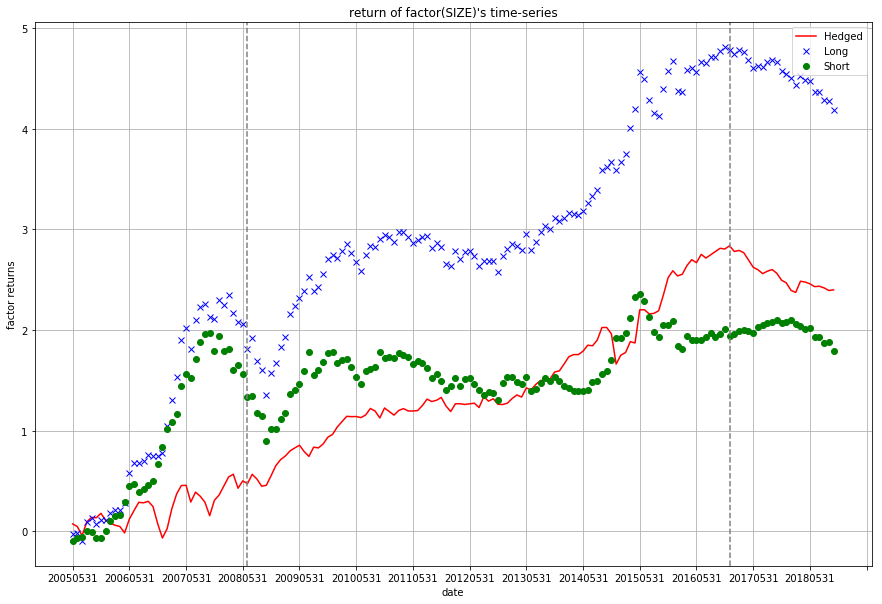

In [33]:
facname = 'SIZE'
print(factor_total[f'{facname}_hedged_ret'].describe())
plot_factor(factor_total, f'{facname}')

count    162.000000
mean       0.007048
std        0.061006
min       -0.230469
25%       -0.031243
50%        0.010372
75%        0.041218
max        0.293845
Name: BP_hedged_ret, dtype: float64


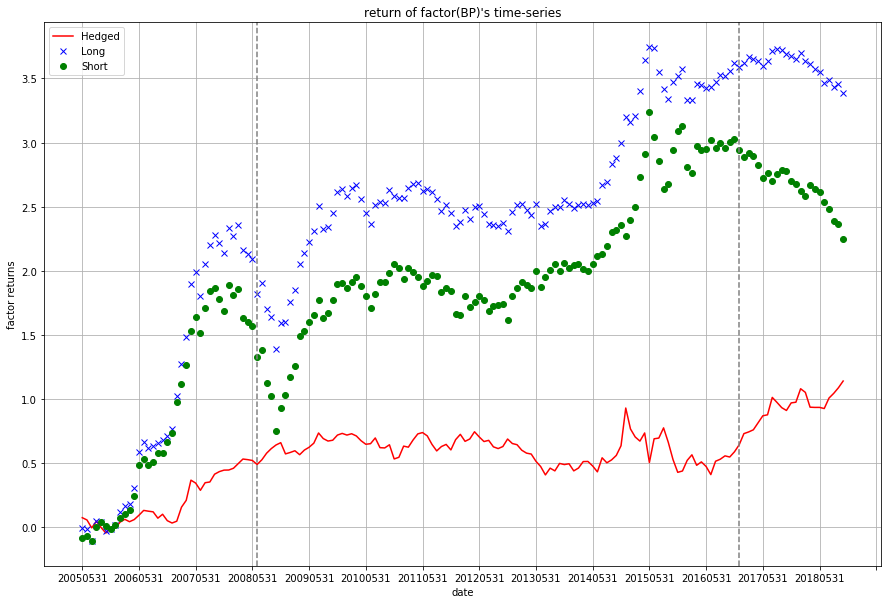

In [34]:
facname = 'BP'
print(factor_total[f'{facname}_hedged_ret'].describe())
plot_factor(factor_total, f'{facname}')

count    162.000000
mean       0.002225
std        0.053708
min       -0.168031
25%       -0.031897
50%        0.001701
75%        0.030971
max        0.223589
Name: EP_hedged_ret, dtype: float64


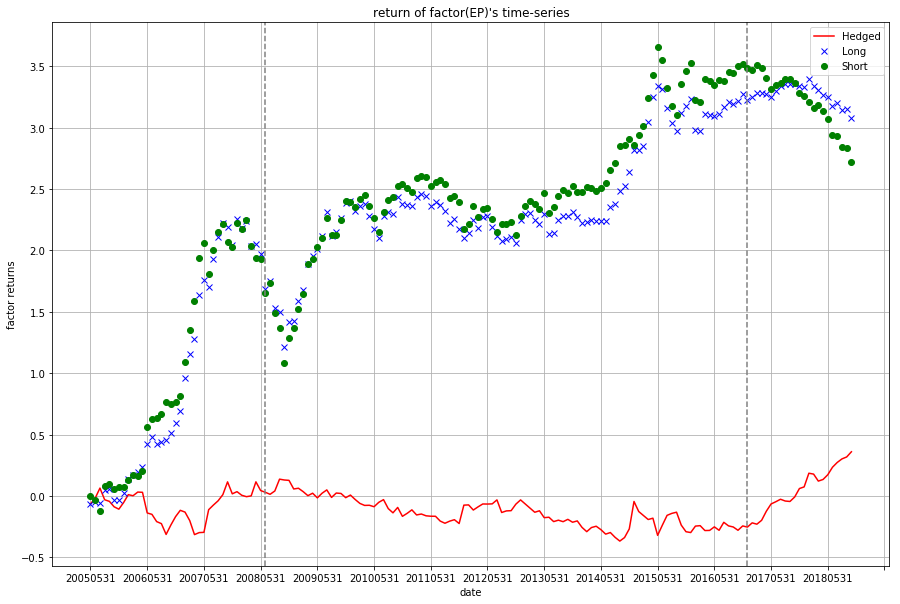

In [35]:
facname = 'EP'
print(factor_total[f'{facname}_hedged_ret'].describe())
plot_factor(factor_total, f'{facname}')

count    162.000000
mean       0.005040
std        0.047963
min       -0.181838
25%       -0.022658
50%        0.006733
75%        0.032276
max        0.204477
Name: SP_hedged_ret, dtype: float64


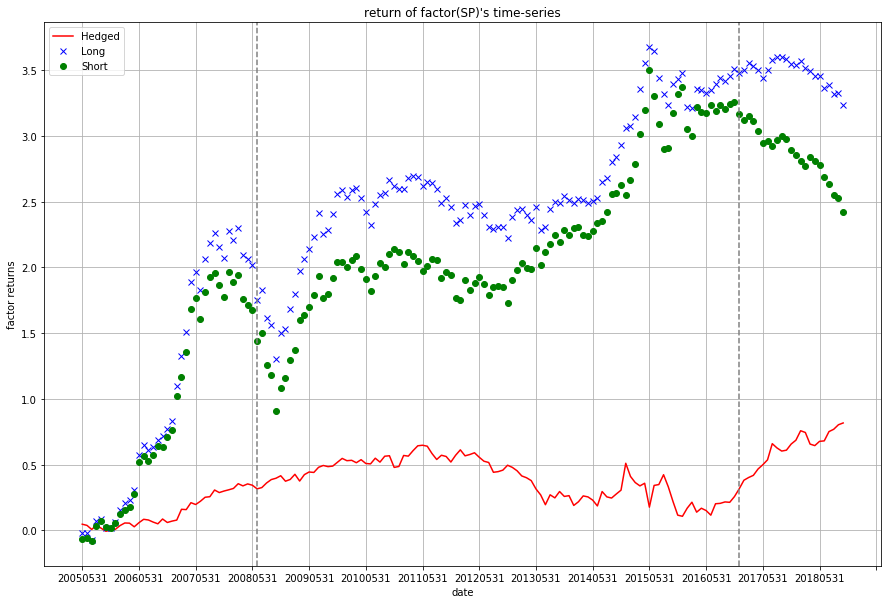

In [36]:
facname = 'SP'
print(factor_total[f'{facname}_hedged_ret'].describe())
plot_factor(factor_total, f'{facname}')

count    162.000000
mean       0.004597
std        0.049387
min       -0.200979
25%       -0.023291
50%        0.003941
75%        0.034908
max        0.237650
Name: DP_hedged_ret, dtype: float64


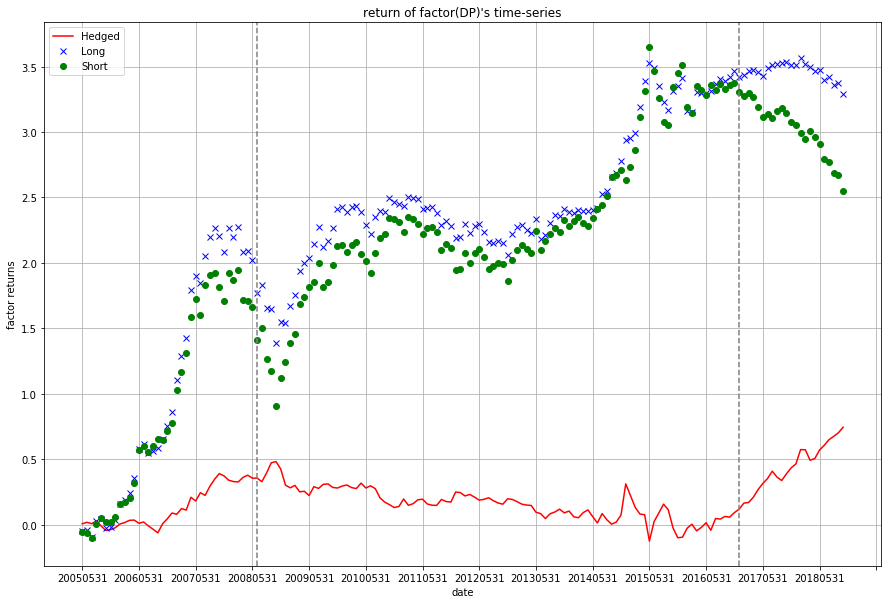

In [37]:
facname = 'DP'
print(factor_total[f'{facname}_hedged_ret'].describe())
plot_factor(factor_total, f'{facname}')

count    162.000000
mean      -0.000499
std        0.051997
min       -0.153773
25%       -0.032671
50%        0.000622
75%        0.029503
max        0.254028
Name: GP_hedged_ret, dtype: float64


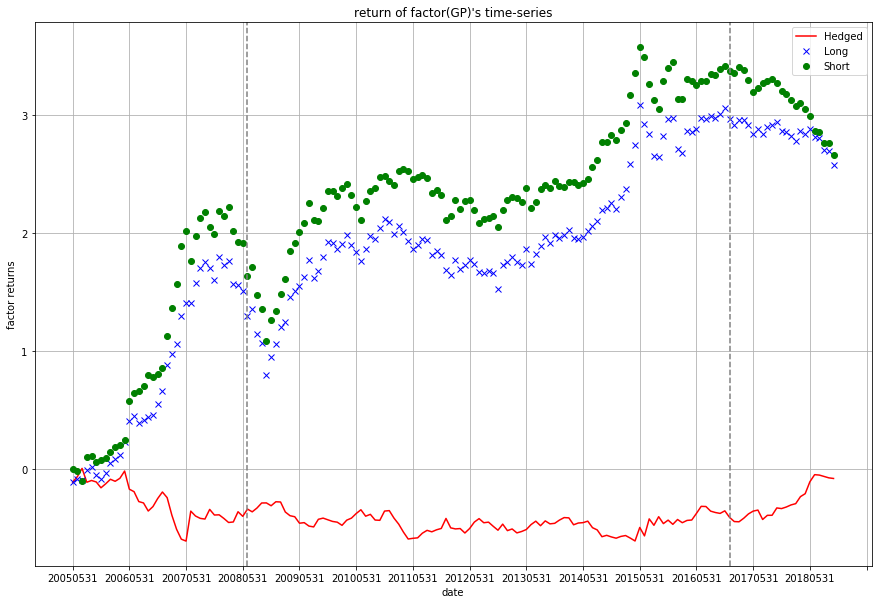

In [38]:
facname = 'GP'
print(factor_total[f'{facname}_hedged_ret'].describe())
plot_factor(factor_total, f'{facname}')

count    162.000000
mean      -0.002989
std        0.044942
min       -0.150841
25%       -0.026769
50%       -0.006033
75%        0.024340
max        0.205763
Name: OP_hedged_ret, dtype: float64


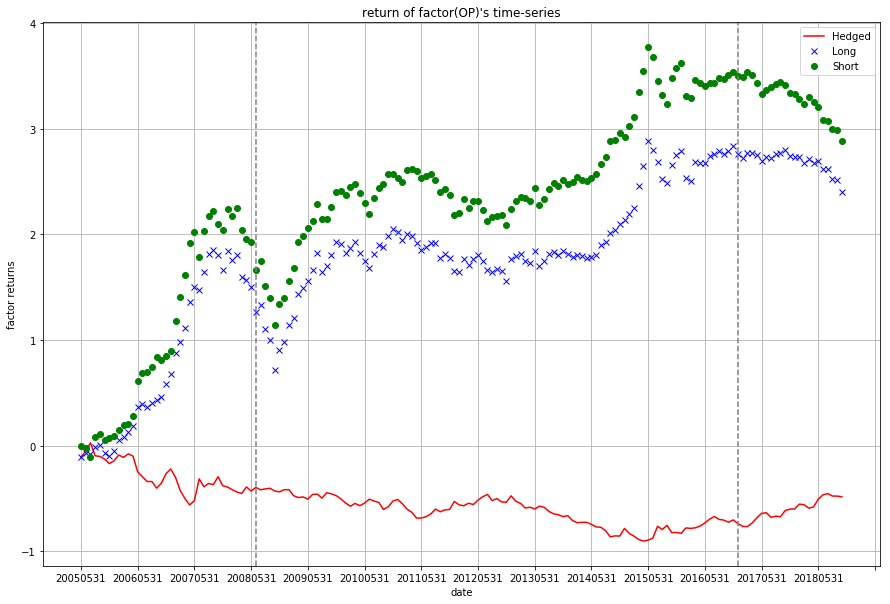

In [39]:
facname = 'OP'
print(factor_total[f'{facname}_hedged_ret'].describe())
plot_factor(factor_total, f'{facname}')

count    162.000000
mean       0.001064
std        0.038389
min       -0.193622
25%       -0.020891
50%        0.003161
75%        0.023111
max        0.113682
Name: D_ASSET_hedged_ret, dtype: float64


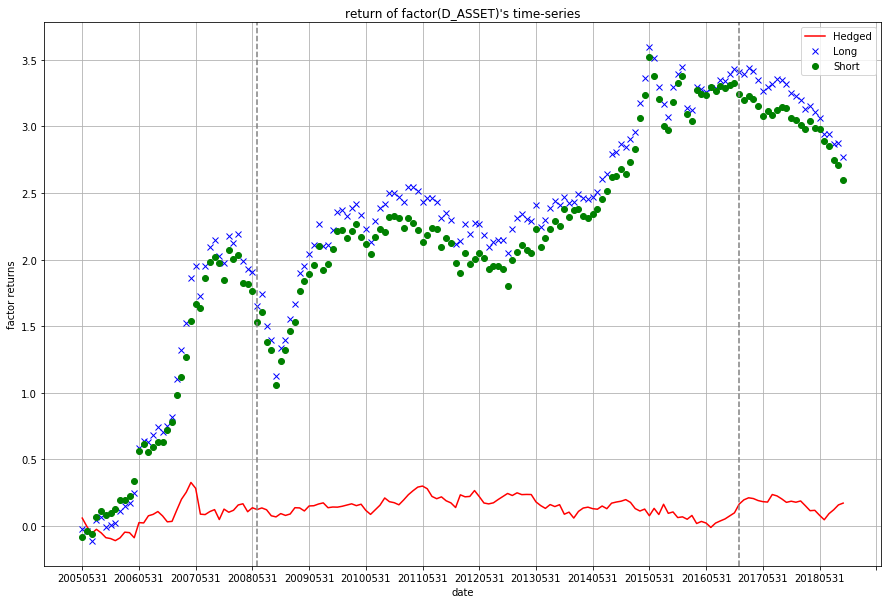

In [40]:
facname = 'D_ASSET'
print(factor_total[f'{facname}_hedged_ret'].describe())
plot_factor(factor_total, f'{facname}')

count    162.000000
mean       0.001082
std        0.043760
min       -0.175743
25%       -0.026168
50%       -0.000230
75%        0.027485
max        0.145111
Name: D_BOOK_hedged_ret, dtype: float64


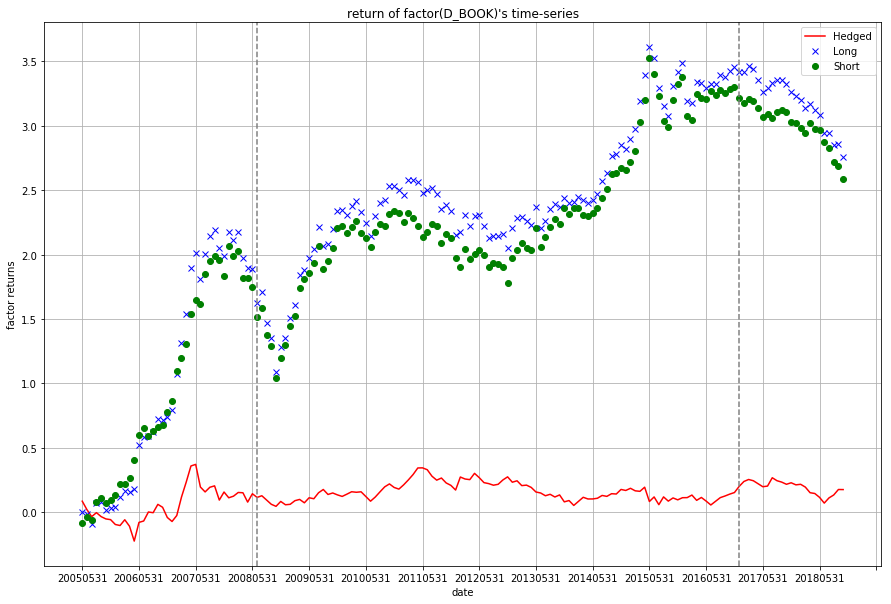

In [41]:
facname = 'D_BOOK'
print(factor_total[f'{facname}_hedged_ret'].describe())
plot_factor(factor_total, f'{facname}')

count    162.000000
mean       0.002302
std        0.029191
min       -0.090699
25%       -0.016237
50%        0.002401
75%        0.018586
max        0.150492
Name: ACC_hedged_ret, dtype: float64


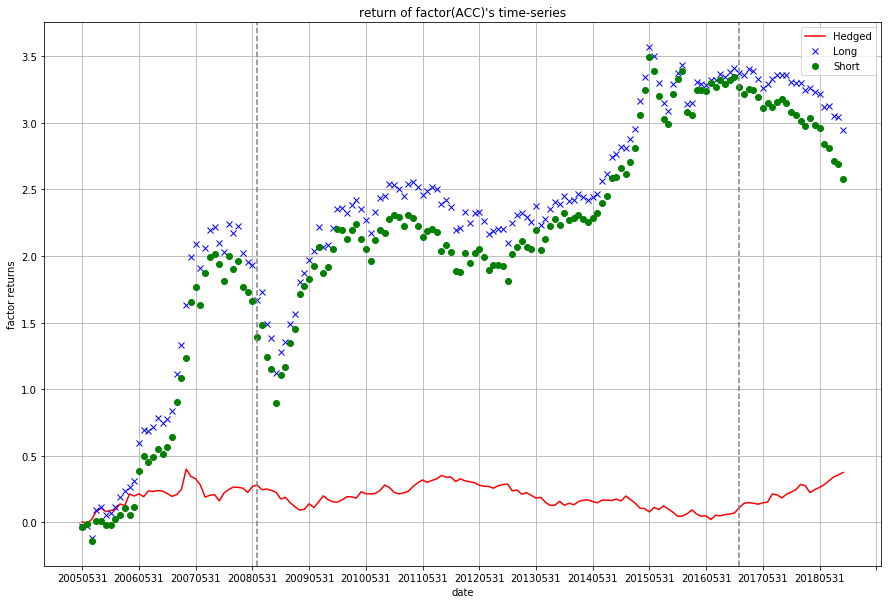

In [42]:
facname = 'ACC'
print(factor_total[f'{facname}_hedged_ret'].describe())
plot_factor(factor_total, f'{facname}')

count    162.000000
mean      -0.003558
std        0.027213
min       -0.097548
25%       -0.020154
50%       -0.002044
75%        0.014295
max        0.070283
Name: NOA_hedged_ret, dtype: float64


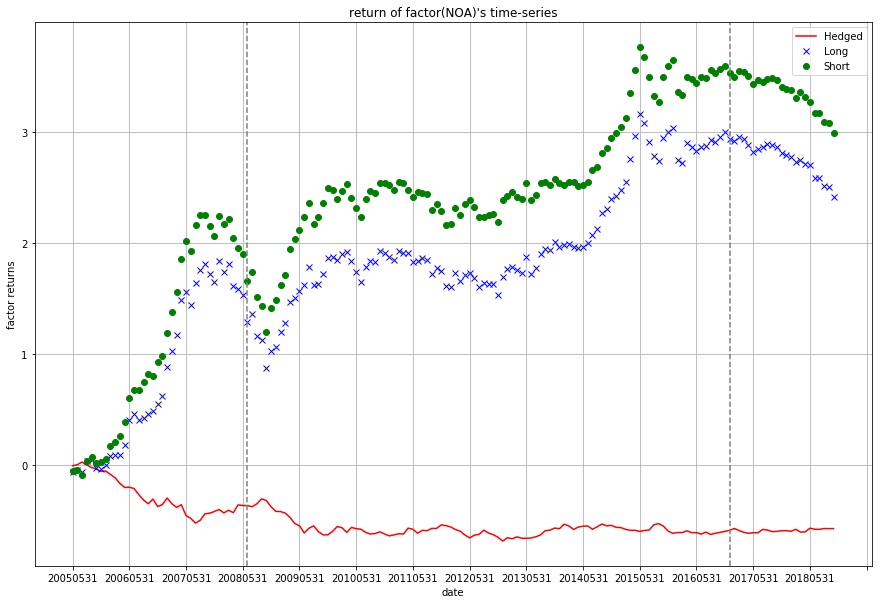

In [43]:
facname = 'NOA'
print(factor_total[f'{facname}_hedged_ret'].describe())
plot_factor(factor_total, f'{facname}')

count    162.000000
mean      -0.006228
std        0.058219
min       -0.156178
25%       -0.041865
50%       -0.006345
75%        0.035306
max        0.207078
Name: MOM_hedged_ret, dtype: float64


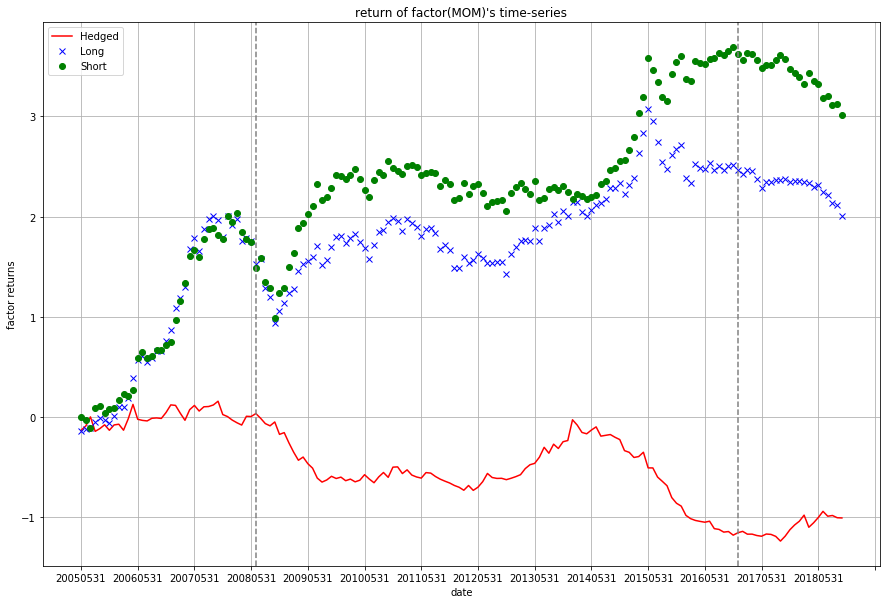

In [44]:
facname = 'MOM'
print(factor_total[f'{facname}_hedged_ret'].describe())
plot_factor(factor_total, f'{facname}')

count    162.000000
mean       0.019827
std        0.057679
min       -0.172149
25%       -0.014705
50%        0.016906
75%        0.045218
max        0.254889
Name: REV_ST_hedged_ret, dtype: float64


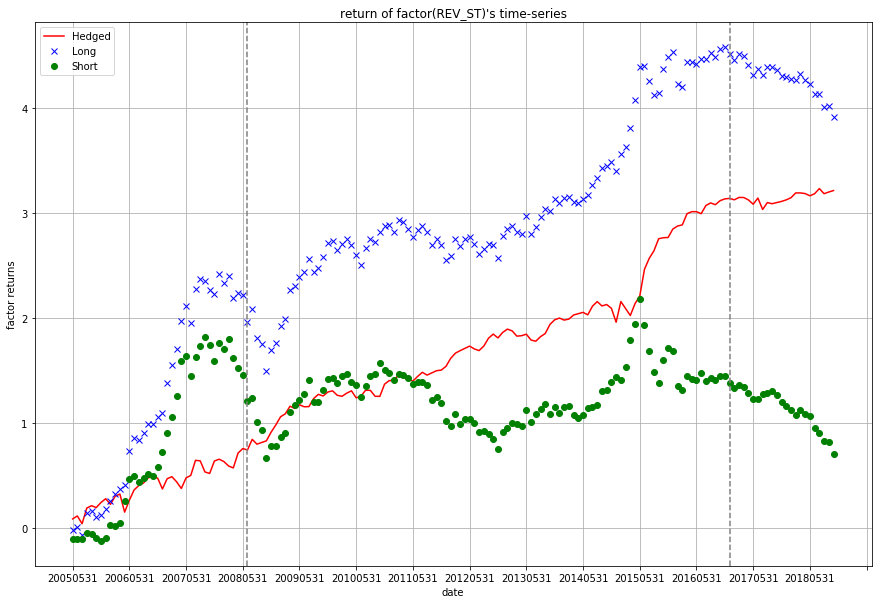

In [45]:
facname = 'REV_ST'
print(factor_total[f'{facname}_hedged_ret'].describe())
plot_factor(factor_total, f'{facname}')

count    162.000000
mean       0.007893
std        0.055397
min       -0.243853
25%       -0.023641
50%        0.006063
75%        0.036249
max        0.174173
Name: REV_LT_hedged_ret, dtype: float64


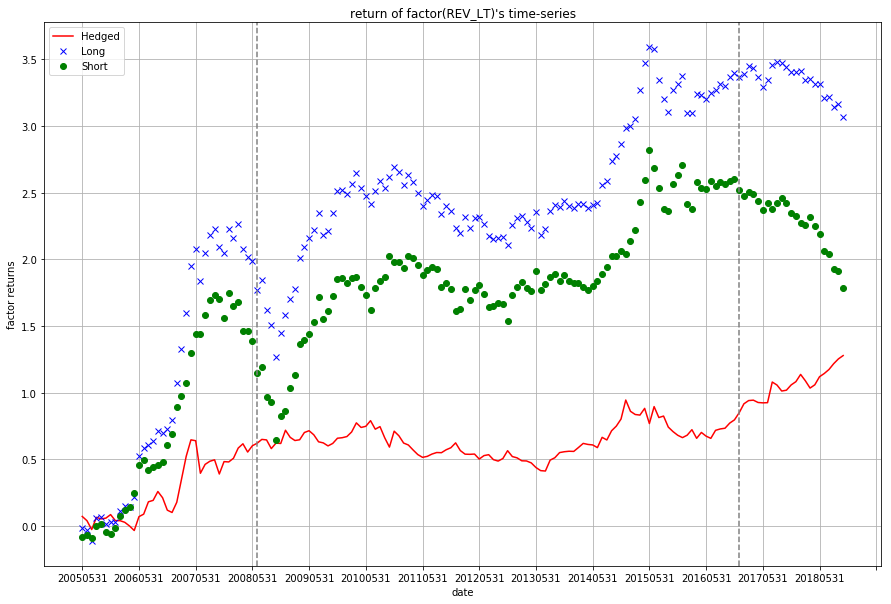

In [46]:
facname = 'REV_LT'
print(factor_total[f'{facname}_hedged_ret'].describe())
plot_factor(factor_total, f'{facname}')